In [1]:
#!/usr/bin/env python
# coding: utf-8

In[1]:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In[2]:

In [3]:
fig_output_dir_p1 = "./figures/p1"
os.makedirs(fig_output_dir_p1, exist_ok=True)

In [4]:
current_dir = Path.cwd()

In [5]:
data_dir = current_dir.parent / "data"
data_dir = data_dir.resolve() 

In[3]:

In [6]:
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig

# Punto 1

## Punto 1.1

#### Inicialización de la configuración del dataset

In[4]:

In [7]:
data_dir_p1 = data_dir / "p1"

In [8]:
config_cell_diagnosis = DatasetConfig(
        data_dir=data_dir_p1,
        target_column="Diagnosis",
        split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
    )

In [9]:
loader_cell_diagnosis = DataLoader(config_cell_diagnosis)

In [10]:
loader_cell_diagnosis.load_data(
        dev_file="raw/cell_diagnosis_balanced_dev.csv",
        test_file='raw/cell_diagnosis_balanced_test.csv',
        splitted=False
    );

In [11]:
cell_diagnosis_balanced_dev_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=False)

Se busca si hay features que tengan valores nulos

In[5]:

In [12]:
def analyze_null_values(dataframes, dataset_names=None):
    """
    Analiza y muestra información detallada sobre valores nulos en uno o más DataFrames.
    Parameters
    ----------
    dataframes : list or pd.DataFrame
        Un DataFrame o lista de DataFrames para analizar
    dataset_names : list, optional
        Lista de nombres para identificar cada DataFrame. Si es None, se usarán nombres genéricos.
    Returns
    -------
    dict
        Diccionario con los resultados del análisis para cada DataFrame
    """
    from IPython.display import display, HTML
    import pandas as pd

    # Convertir entrada única a lista para procesamiento uniforme
    if not isinstance(dataframes, list):
        dataframes = [dataframes]

    # Generar nombres por defecto si no se proporcionan
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    elif len(dataset_names) != len(dataframes):
        dataset_names = [f"Dataset {i+1}" for i in range(len(dataframes))]
    results = {}
    for df, name in zip(dataframes, dataset_names):
        print(f"Valores nulos en {name}:")

        # Análisis de valores nulos por columna
        null_counts = df.isnull().sum()
        total_rows = len(df)
        null_percentage = (null_counts / total_rows) * 100

        # Crear DataFrame para mostrar como tabla
        null_table = pd.DataFrame({
            'Columna': null_counts.index,
            'Cantidad de nulos': null_counts.values,
            'Porcentaje (%)': null_percentage.values.round(2)
        })
        display(null_table)

        # Información de muestras con valores nulos
        samples_with_nulls = df.isnull().any(axis=1).sum()
        samples_without_nulls = total_rows - samples_with_nulls
        samples_percentage = (samples_with_nulls / total_rows) * 100
        summary = pd.DataFrame({
            'Métrica': ['Muestras con al menos un valor nulo', 'Muestras sin valores nulos', 'Total de muestras'],
            'Cantidad': [samples_with_nulls, samples_without_nulls, total_rows],
            'Porcentaje (%)': [samples_percentage.round(2), (100-samples_percentage).round(2), 100.0]
        })
        display(summary)

        # Guardar resultados
        results[name] = {
            'null_table': null_table,
            'summary': summary,
            'total_nulls': null_counts.sum(),
            'total_rows': total_rows,
            'null_percentage': (null_counts.sum() / (total_rows * len(df.columns)) * 100).round(2)
        }
        print("\n")
    return results

Analizar valores nulos en ambos conjuntos de datos

In [13]:
def train_valid_split(df, test_size=0.2, random_state=42):
    """
    Split a DataFrame into training and validation sets.
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to split
    test_size : float, default=0.2
        The proportion of the dataset to include in the validation split
    random_state : int, default=42
        Controls the shuffling applied to the data before applying the split
    Returns
    -------
    tuple
        (train_df, valid_df) - The split DataFrames
    """
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_size)
    valid_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[valid_indices]

In [14]:
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers = train_valid_split(
    cell_diagnosis_balanced_dev_outliers, test_size=0.2, random_state=12
)

In [15]:
analyze_null_values(
    [cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_test_outliers],
    ["conjunto de train", "conjunto de prueba"]
);

Valores nulos en conjunto de train:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                258           19.38
1             CellShape                253           19.01
2        NucleusDensity                235           17.66
3      ChromatinTexture                240           18.03
4         CytoplasmSize                245           18.41
5          CellAdhesion                234           17.58
6           MitosisRate                261           19.61
7       NuclearMembrane                248           18.63
8          GrowthFactor                239           17.96
9      OxygenSaturation                229           17.21
10      Vascularization                246           18.48
11  InflammationMarkers                252           18.93
12            Diagnosis                  0            0.00
13             CellType                202           15.18
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo      1228           92.26
1           Muestras sin valores nulos       103            7.74
2                    Total de muestras      1331          100.00



Valores nulos en conjunto de prueba:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 35           18.92
1             CellShape                 41           22.16
2        NucleusDensity                 32           17.30
3      ChromatinTexture                 35           18.92
4         CytoplasmSize                 33           17.84
5          CellAdhesion                 29           15.68
6           MitosisRate                 36           19.46
7       NuclearMembrane                 25           13.51
8          GrowthFactor                 40           21.62
9      OxygenSaturation                 31           16.76
10      Vascularization                 40           21.62
11  InflammationMarkers                 36           19.46
12            Diagnosis                  0            0.00
13             CellType                 31           16.76
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       172           92.97
1           Muestras sin valores nulos        13            7.03
2                    Total de muestras       185          100.00

In[6]:

In [16]:
from preprocessing.imputation import KNNImputer

In[7]:

In [17]:
def impute_missing_values(train_df, valid_df=None, test_df=None, knn_neighbors=8, knn_weights='distance'):
    """
    Impute missing values in datasets using a two-step approach:
    1. First impute with mean/mode from training data
    2. Then refine with KNN imputation
    Parameters
    ----------
    train_df : pd.DataFrame
        Training dataset
    valid_df : pd.DataFrame, optional
        Validation dataset
    test_df : pd.DataFrame, optional
        Test dataset
    knn_neighbors : int, default=8
        Number of neighbors to use for KNN imputation
    knn_weights : str, default='distance'
        Weight function used in prediction by KNN imputation
    Returns
    -------
    tuple
        Tuple containing the imputed DataFrames in the same order as provided
    """
    # Reset indices for all dataframes
    train_df = train_df.reset_index(drop=True)
    if valid_df is not None:
        valid_df = valid_df.reset_index(drop=True)
    if test_df is not None:
        test_df = test_df.reset_index(drop=True)

    # Print information about missing values before imputation
    print("Missing values before imputation:")
    print(f"Train: {train_df.isna().sum().sum()} missing values")
    if valid_df is not None:
        print(f"Valid: {valid_df.isna().sum().sum()} missing values")
    if test_df is not None:
        print(f"Test: {test_df.isna().sum().sum()} missing values")

        # Step 2: Apply KNN imputation to refine the results

    custom_imputer = KNNImputer(n_neighbors=knn_neighbors, weights=knn_weights, return_df=True)
    custom_imputer.fit(train_df)

    # Transform all datasets
    imputed_train = custom_imputer.transform(train_df)
    imputed_valid = custom_imputer.transform(valid_df) if valid_df is not None else None
    imputed_test = custom_imputer.transform(test_df) if test_df is not None else None

    # Print information about missing values after imputation
    print("\nMissing values after imputation:")
    print(f"Train: {imputed_train.isna().sum().sum()} missing values")
    if imputed_valid is not None:
        print(f"Valid: {imputed_valid.isna().sum().sum()} missing values")
    if imputed_test is not None:
        print(f"Test: {imputed_test.isna().sum().sum()} missing values")

    # Return imputed datasets in the same order they were provided
    result = [imputed_train]
    if valid_df is not None:
        result.append(imputed_valid)
    if test_df is not None:
        result.append(imputed_test)
    return tuple(result) if len(result) > 1 else result[0]

In[8]:

Apply the imputation process

In [18]:
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers, cell_diagnosis_balanced_test_outliers = impute_missing_values(
    cell_diagnosis_balanced_train_outliers,
    cell_diagnosis_balanced_valid_outliers,
    cell_diagnosis_balanced_test_outliers,
    knn_neighbors=8,
    knn_weights='distance'
)

Missing values before imputation:
Train: 3142 missing values
Valid: 821 missing values
Test: 444 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


Si ya se realizó el preprocesamiento, comentar el siguiente codigo

In[9]:

In [19]:
loader_cell_diagnosis.update(df_train=cell_diagnosis_balanced_train_outliers, df_valid=cell_diagnosis_balanced_valid_outliers, df_test=cell_diagnosis_balanced_test_outliers);

In [20]:
df_preprocessed_cell_diagnosis_test_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_balanced_test.csv"
df_preprocessed_cell_diagnosis_train_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_balanced_train.csv"
df_preprocessed_cell_diagnosis_valid_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_balanced_valid.csv"

In [21]:
loader_cell_diagnosis.save_processed_data(df_train_dir=df_preprocessed_cell_diagnosis_train_dir, df_valid_dir=df_preprocessed_cell_diagnosis_valid_dir, df_test_dir=df_preprocessed_cell_diagnosis_test_dir)

Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_balanced_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_balanced_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_balanced_test.csv


In[10]:

In [22]:
loader_cell_diagnosis.load_data(
        train_file="preprocessed/cell_diagnosis_balanced_train.csv",
        valid_file='preprocessed/cell_diagnosis_balanced_valid.csv',
        test_file='preprocessed/cell_diagnosis_balanced_test.csv',
        splitted=True
    )

In [23]:
cell_diagnosis_balanced_train_outliers, cell_diagnosis_balanced_valid_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=True)

In[11]:

In [24]:
from utils.utils import print_numerical_features_range

In[12]:

In [25]:
print_numerical_features_range(cell_diagnosis_balanced_train_outliers);

Rango de cada feature numérica (13 features):


Se analiza el conjunto de dev completamente<br>
No es necesario hacer esto con el test

In[13]:

In [26]:
from utils.visuals import (analyze_categorical_variables,plot_numerical_distributions, plot_correlation_heatmap
                          )

In [27]:
exclude_columns = ["Diagnosis"]
numerical_cols_cell_diagnosis_balanced_train_outliers = cell_diagnosis_balanced_train_outliers.select_dtypes(include=['number']).columns.tolist()

In [28]:
numerical_cols_cell_diagnosis_balanced_train_outliers = [col for col in numerical_cols_cell_diagnosis_balanced_train_outliers if col not in exclude_columns]

In [29]:
analyze_categorical_variables(cell_diagnosis_balanced_train_outliers, ["CellType", "GeneticMutation",'Diagnosis']);

Categorical variables distribution:

CellType distribution:


CellType  Count  Percentage (%)
0         ???    597           44.85
1    Epthlial    380           28.55
2  Mesnchymal    354           26.60


GeneticMutation distribution:


GeneticMutation  Count  Percentage (%)
0          Presnt    690           51.84
1           Absnt    641           48.16


Diagnosis distribution:


Diagnosis  Count  Percentage (%)
0        0.0    738           55.45
1        1.0    593           44.55

In[14]:

In[15]:

In [30]:
ALL_FEATURES = cell_diagnosis_balanced_train_outliers.columns.tolist()
FEATURES_TO_PLOT = ['CellSize', 'MitosisRate', 'NucleusDensity']

In[16]:

Saved figure to figures/numerical_distributions_outliers.png


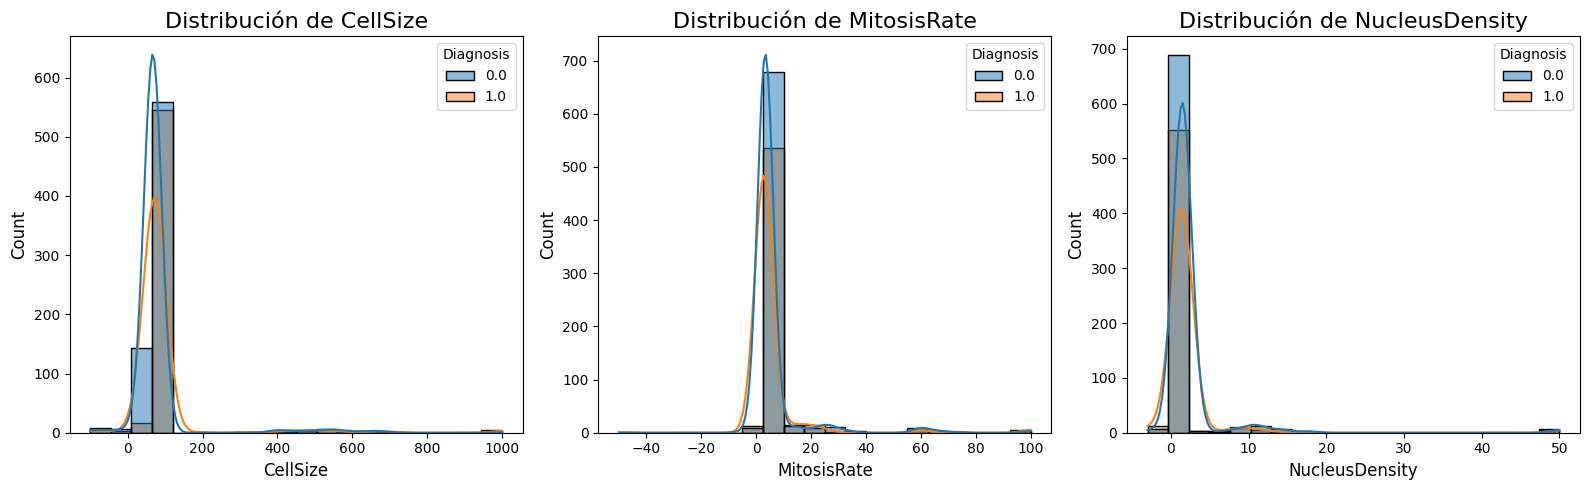

In [31]:
fig = plot_numerical_distributions(cell_diagnosis_balanced_train_outliers, numerical_cols_cell_diagnosis_balanced_train_outliers, "Diagnosis",features_to_plot=FEATURES_TO_PLOT,figsize=(16,5),output_dir="figures",filename="numerical_distributions_outliers.png")
plt.show()

In[17]:

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_outliers.png


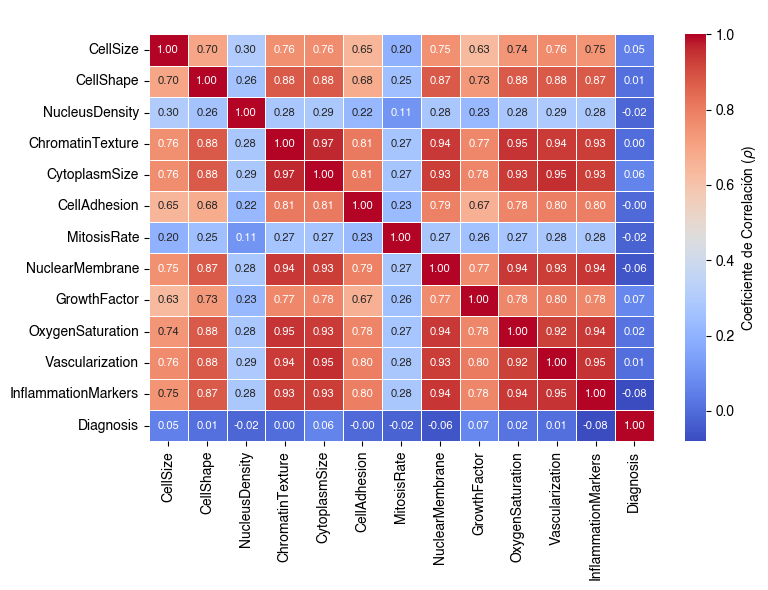

In [32]:
fig = plot_correlation_heatmap(
    cell_diagnosis_balanced_train_outliers, 
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_outliers.png",
    title=' ',
    figsize=(8,6),
)
plt.show()

Observamos que hay muchos outliers

In[18]:

In [33]:
from utils.visuals import plot_outliers_analysis

Gráfico guardado en: ./figures/p1/boxplots_outliers_analysis.png


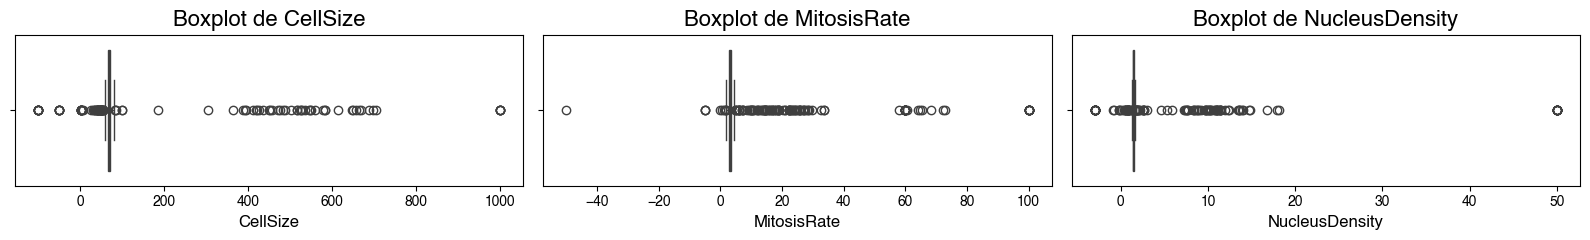

In [34]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_balanced_train_outliers, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    filename='boxplots_outliers_analysis.png',
    figsize=(16, 5),
    show_plots=True
)

In[ ]:

In [35]:
from preprocessing.outliers import replace_outliers_iqr

Si ya se realizó el preprocesamiento, comentar el siguiente codigo

In[20]:

In [36]:
cell_diagnosis_balanced_train, params = replace_outliers_iqr(cell_diagnosis_balanced_train_outliers, method='winsorize', return_params=True,target_column="Diagnosis")
cell_diagnosis_balanced_valid = replace_outliers_iqr(cell_diagnosis_balanced_valid_outliers, method='winsorize', params=params,target_column="Diagnosis")
cell_diagnosis_balanced_test = replace_outliers_iqr(cell_diagnosis_balanced_test_outliers, method='winsorize', params=params,target_column="Diagnosis")

In [37]:
cell_diagnosis_balanced_dev = pd.concat([cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid])

In [38]:
loader_cell_diagnosis.update(
    df_train=cell_diagnosis_balanced_train,
    df_valid=cell_diagnosis_balanced_valid,
    df_test=cell_diagnosis_balanced_test
)

In [39]:
df_cell_diagnosis_train_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_train.csv"
df_cell_diagnosis_valid_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_valid.csv"
df_cell_diagnosis_test_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_test.csv"
df_cell_diagnosis_dev_dir = data_dir / "p1" / "processed" / "cell_diagnosis_balanced_dev.csv"

In [40]:
pd.DataFrame(cell_diagnosis_balanced_dev).to_csv(df_cell_diagnosis_dev_dir, index=False)

In [41]:
loader_cell_diagnosis.save_processed_data(
    df_train_dir=df_cell_diagnosis_train_dir,
    df_valid_dir=df_cell_diagnosis_valid_dir,
    df_test_dir=df_cell_diagnosis_test_dir,
    df_dev_dir=df_cell_diagnosis_dev_dir
)

Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_test.csv
Development data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_balanced_dev.csv


In[21]:

In [42]:
loader_cell_diagnosis.load_data(
    train_file="processed/cell_diagnosis_balanced_train.csv",
    valid_file='processed/cell_diagnosis_balanced_valid.csv',
    test_file='processed/cell_diagnosis_balanced_test.csv',
    splitted=True
)

In [43]:
cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid, cell_diagnosis_balanced_test = loader_cell_diagnosis.get_pandas_data(splitted=True)

In[22]:

In [44]:
print_numerical_features_range(cell_diagnosis_balanced_valid);

Rango de cada feature numérica (13 features):


In[23]:

Saved figure to figures/numerical_distributions.png


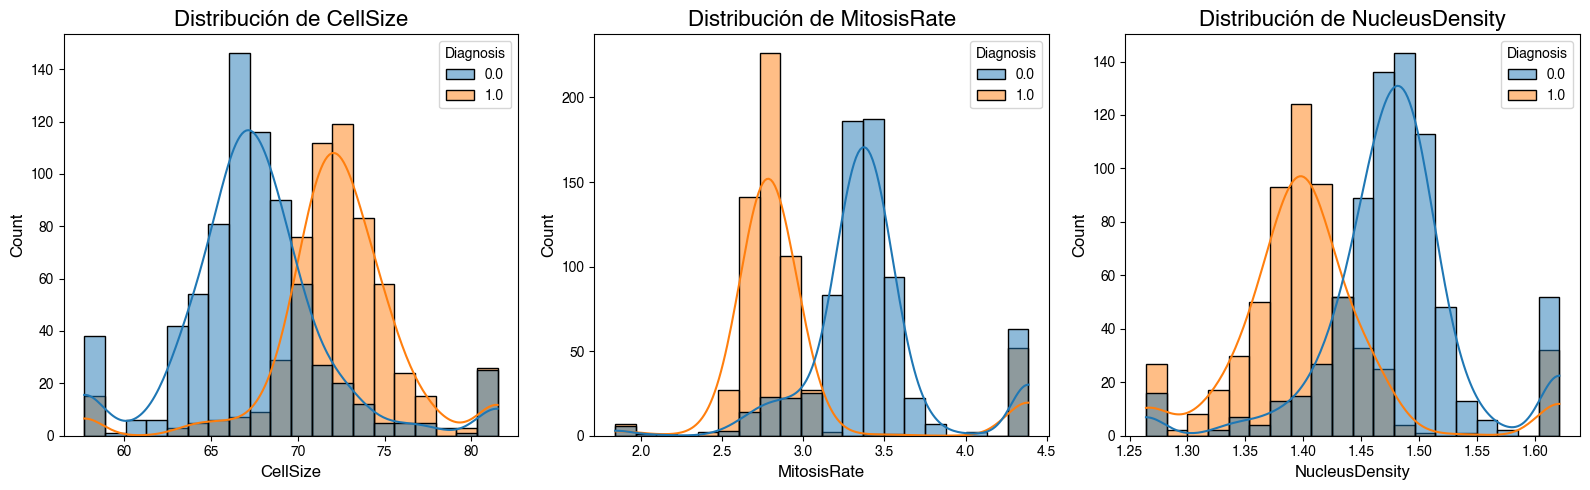

In [45]:
fig = plot_numerical_distributions(
    cell_diagnosis_balanced_train, 
    numerical_cols=numerical_cols_cell_diagnosis_balanced_train_outliers,
    features_to_plot=FEATURES_TO_PLOT,
    target_column="Diagnosis",
    output_dir='figures',
    filename='numerical_distributions.png',
    figsize=(16, 5)
)

In [46]:
plt.show()

In[24]:

Saved figure to ./figures/p1/correlation_heatmap_numerical_features.png


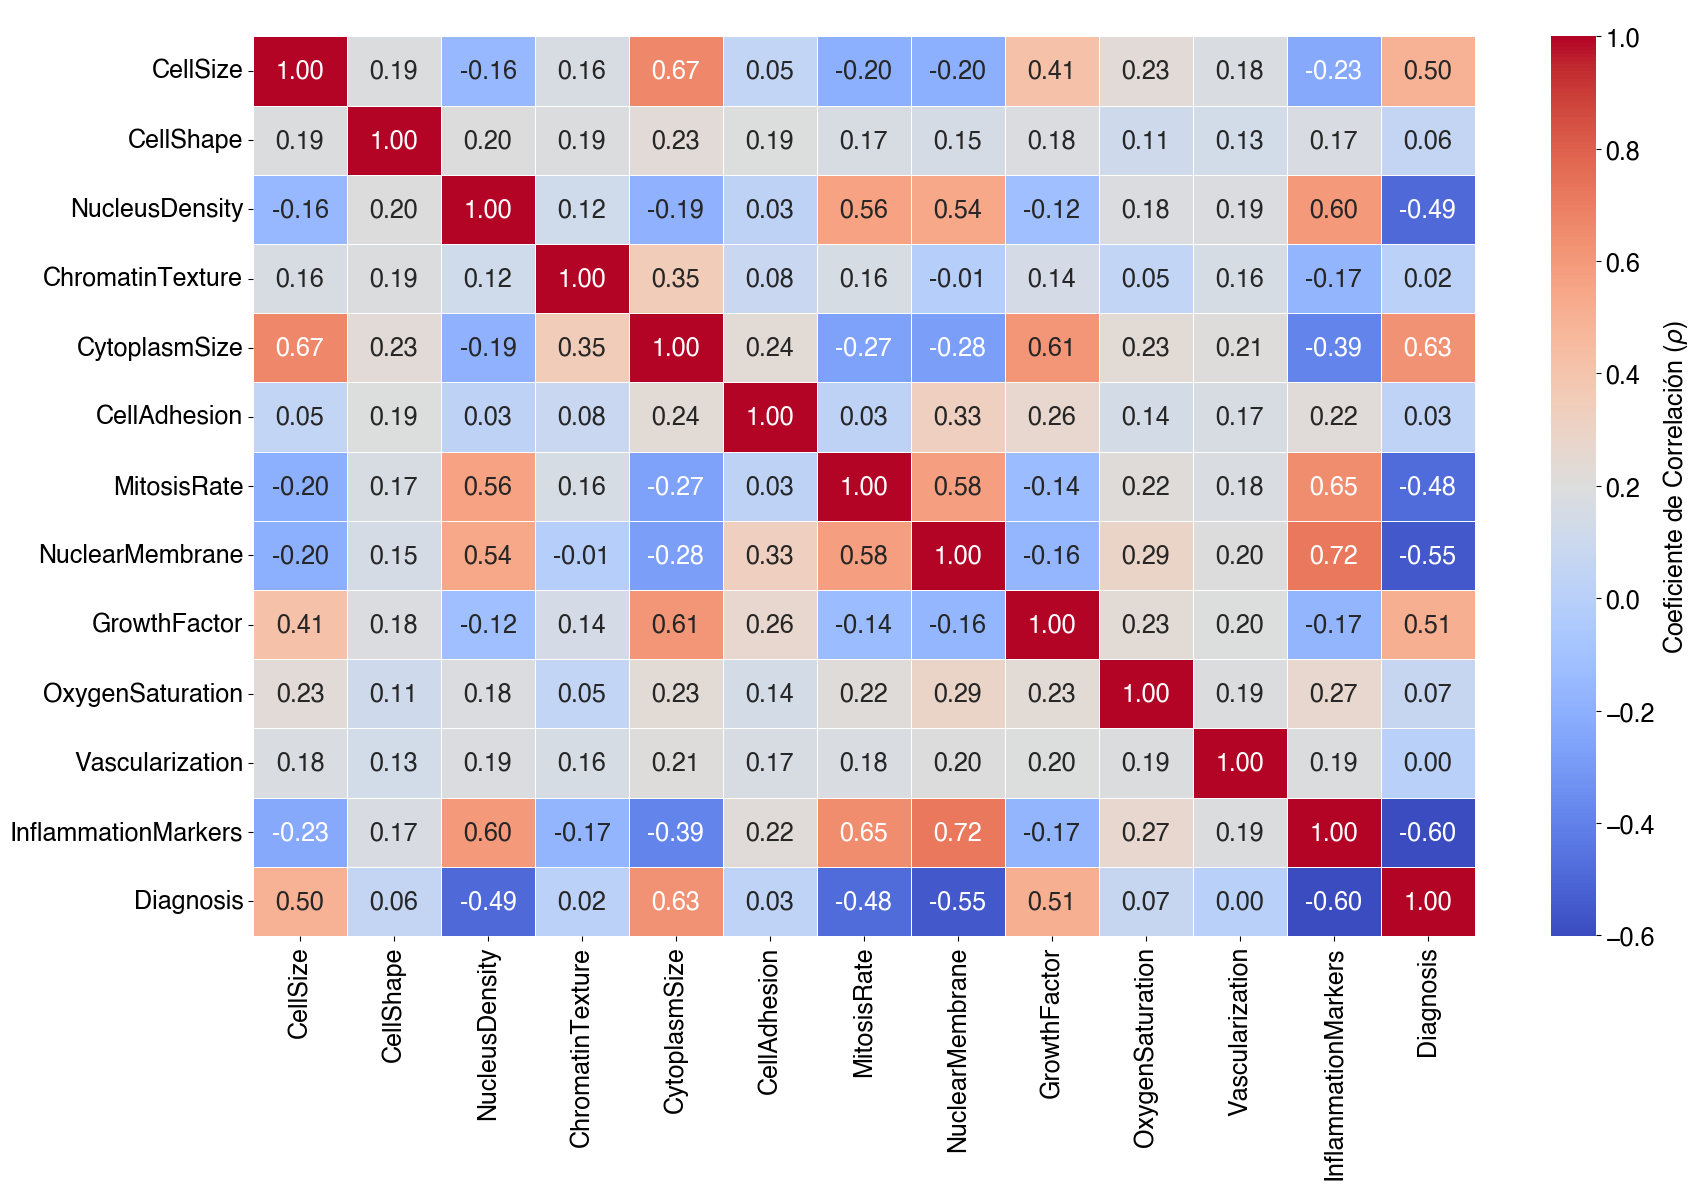

In [47]:
fig = plot_correlation_heatmap(
    cell_diagnosis_balanced_train, 
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features.png",
    title=' ',
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18,12),
)
plt.show()

Son correlaciones bastantes altas considerando que el set de datos es pequeño (valid)

In[25]:

In [48]:
from utils.visuals import plot_outliers_analysis

Gráfico guardado en: ./figures/p1/boxplots_analysis.png


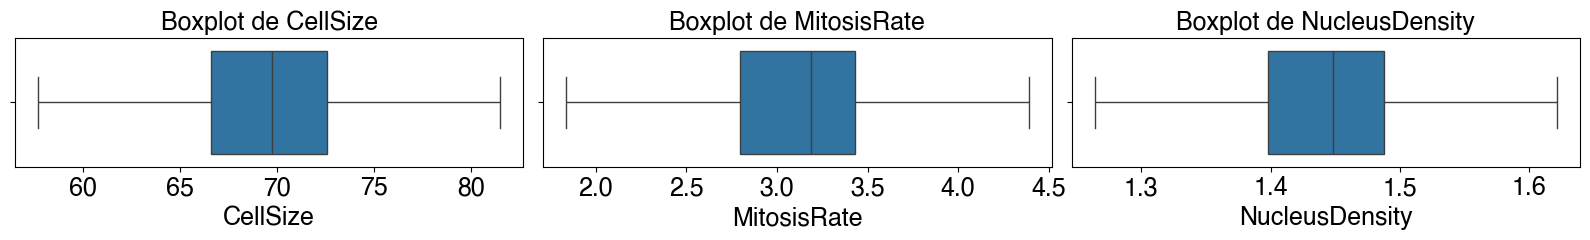

In [49]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_balanced_train, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename='boxplots_analysis.png',
    show_plots=True
)

## Punto 1.2

In[26]:

In [50]:
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig

In[27]:

In [51]:
from evaluation.cross_validation import cross_validate_lambda
from evaluation.metrics import f1_score, recall_score 
from utils.visuals import plot_lambda_tuning
import numpy as np

In[28]:

In [52]:
import pandas as pd

In [53]:
def apply_feature_engineering(df, transformations, inplace=False, verbose=False):
    """
    Aplica transformaciones de feature engineering a un DataFrame.
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    transformations : dict
        Diccionario en el que cada clave es el nombre de la nueva feature y cada valor es una función 
        que recibe el DataFrame y retorna una pd.Series con los valores de la nueva feature.
        Ejemplo:
            {
                "CellSize_Cytoplasm_Ratio": lambda d: d["CellSize"] / d["CytoplasmSize"],
                "LogInflammation": lambda d: np.log1p(d["InflammationMarkers"])
            }
    inplace : bool, default=False
        Si es True, se modifica el DataFrame original; de lo contrario se trabaja sobre una copia.
    verbose : bool, default=False
        Si es True, imprime información sobre cada transformación aplicada.
    Retorna
    -------
    pd.DataFrame
        DataFrame con las nuevas features añadidas.
    """
    if not inplace:
        df = df.copy()
    for new_feature, transform_func in transformations.items():
        if verbose:
            print(f"Aplicando transformación para la feature: '{new_feature}'")
        try:
            df[new_feature] = transform_func(df)
        except Exception as e:
            raise e
    return df

In[29]:

Definir transformaciones básicas

In [54]:
transformations = {
    "Nucleus_Cytoplasm_Ratio": lambda d: (d["CellSize"] - d["CytoplasmSize"]) / d["CytoplasmSize"],
    "ProliferationIndex": lambda d: d["GrowthFactor"] * d["MitosisRate"],
    "DensityTextureIndex": lambda d: d["NucleusDensity"] * d["ChromatinTexture"],
}

Aplicar las transformaciones de feature engineering

In [55]:
cell_diagnosis_balanced_train = apply_feature_engineering(cell_diagnosis_balanced_train, transformations, verbose=False)
cell_diagnosis_balanced_valid = apply_feature_engineering(cell_diagnosis_balanced_valid, transformations, verbose=False)
cell_diagnosis_balanced_test = apply_feature_engineering(cell_diagnosis_balanced_test, transformations, verbose=False)

In[30]:

In [56]:
from evaluation.cross_validation import stratified_cross_validate_lambda

In [57]:
X_train_cell_diagnosis, y_train_cell_diagnosis = cell_diagnosis_balanced_train.drop(columns=["Diagnosis"]), cell_diagnosis_balanced_train["Diagnosis"]

In [58]:
X_train_cell_diagnosis = DataLoader.encode_categorical(X_train_cell_diagnosis)
X_train_cell_diagnosis, y_train_cell_diagnosis = X_train_cell_diagnosis.to_numpy(), y_train_cell_diagnosis.to_numpy()

In [59]:
# Crear una escala logarítmica para tener mejor representación de valores pequeños
lambda_values = np.concatenate([
    np.logspace(-6, -3, 50),  # Valores muy pequeños (10^-6 a 10^-3)
    np.logspace(-3, 1, 200)   # Valores pequeños a medianos (10^-3 a 10^0)
])

In [60]:
best_lambda, mean_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis,
    y=y_train_cell_diagnosis,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.2
)

Plot results manually

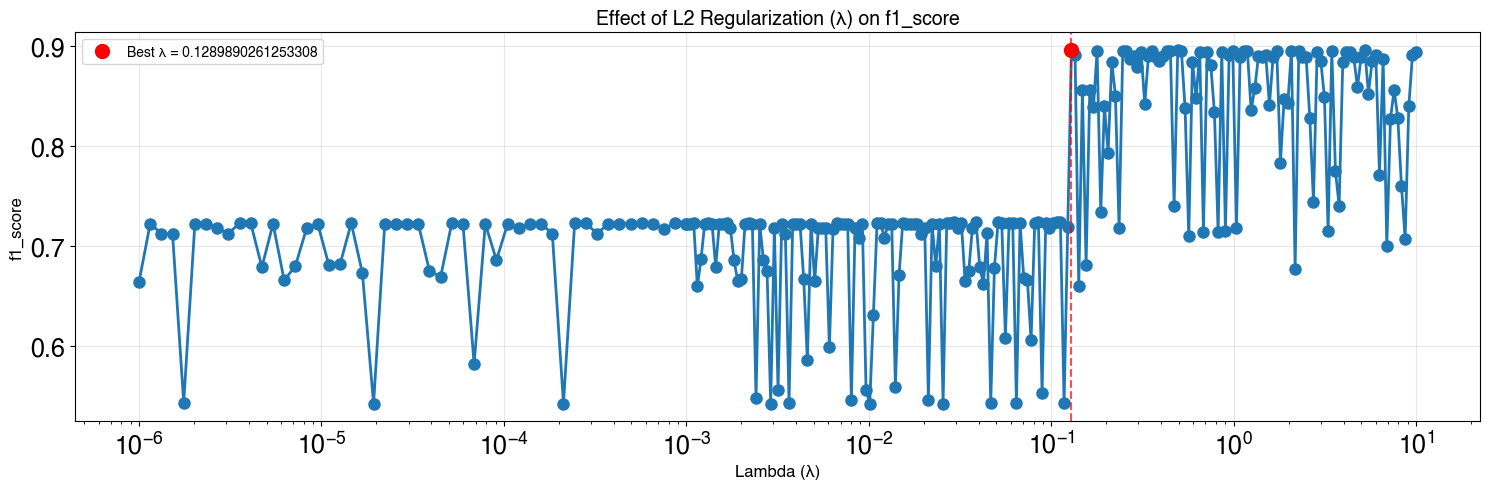

In [61]:
plot_lambda_tuning(
    lambda_values=lambda_values,
    scores=mean_scores,
    metric_name=f1_score.__name__,
    best_lambda=best_lambda,

    figsize=(15, 5),
)

In[31]:

In [62]:
print(f"Optimal lambda value: {best_lambda}")

Optimal lambda value: 0.1289890261253308


In [63]:
final_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda
)

In[32]:

In [64]:
from utils.utils import evaluate_model

In[33]:

In [65]:
X_valid_cell_diagnosis, y_valid_cell_diagnosis = cell_diagnosis_balanced_valid.drop(columns=["Diagnosis"]), cell_diagnosis_balanced_valid["Diagnosis"]

In [66]:
X_valid_cell_diagnosis = DataLoader.encode_categorical(X_valid_cell_diagnosis)
X_valid_cell_diagnosis, y_valid_cell_diagnosis = X_valid_cell_diagnosis.to_numpy(), y_valid_cell_diagnosis.to_numpy()

In [67]:
final_model = LogisticRegression(final_config)

In [68]:
final_model.fit(X_train_cell_diagnosis, y_train_cell_diagnosis);

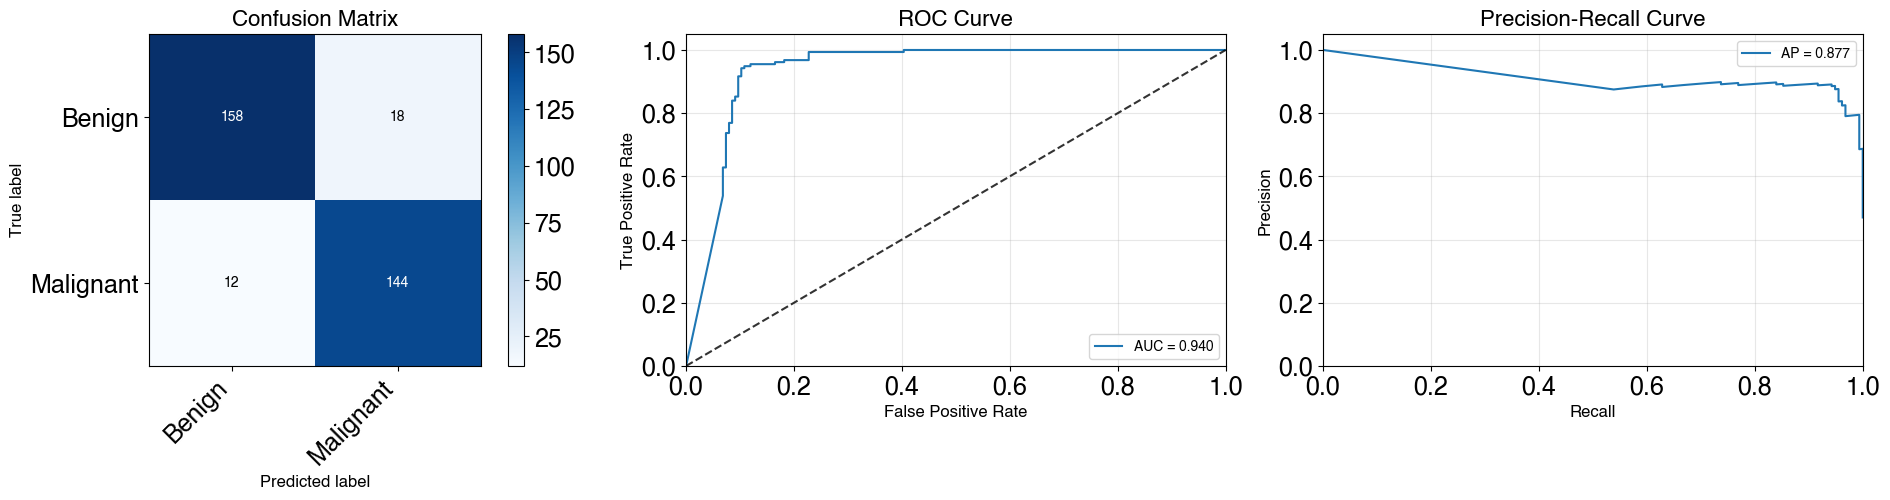


Model Evaluation Metrics:
Confusion Matrix:
[[158  18]
 [ 12 144]]
Accuracy: 0.9096
Precision: 0.8889
Recall: 0.9231
F1 Score: 0.9057
AUC-ROC: 0.9397
AUC-PR: 0.8774


In [69]:
results = evaluate_model(
    threshold=0.2,
    model=final_model, 
    X_test=X_valid_cell_diagnosis, 
    y_test=y_valid_cell_diagnosis, 
    class_names=["Benign", "Malignant"],
    save_dir=fig_output_dir_p1, 
    figsize=(20,5),
    base_filename="test_balanced"
)

## Punto 1.3

In[34]:

In [70]:
X_final_test, y_final_test = cell_diagnosis_balanced_test.drop(columns=["Diagnosis"]), cell_diagnosis_balanced_test["Diagnosis"]

In [71]:
X_final_test = DataLoader.encode_categorical(X_final_test)
X_final_test, y_final_test = X_final_test.to_numpy(), y_final_test.to_numpy()

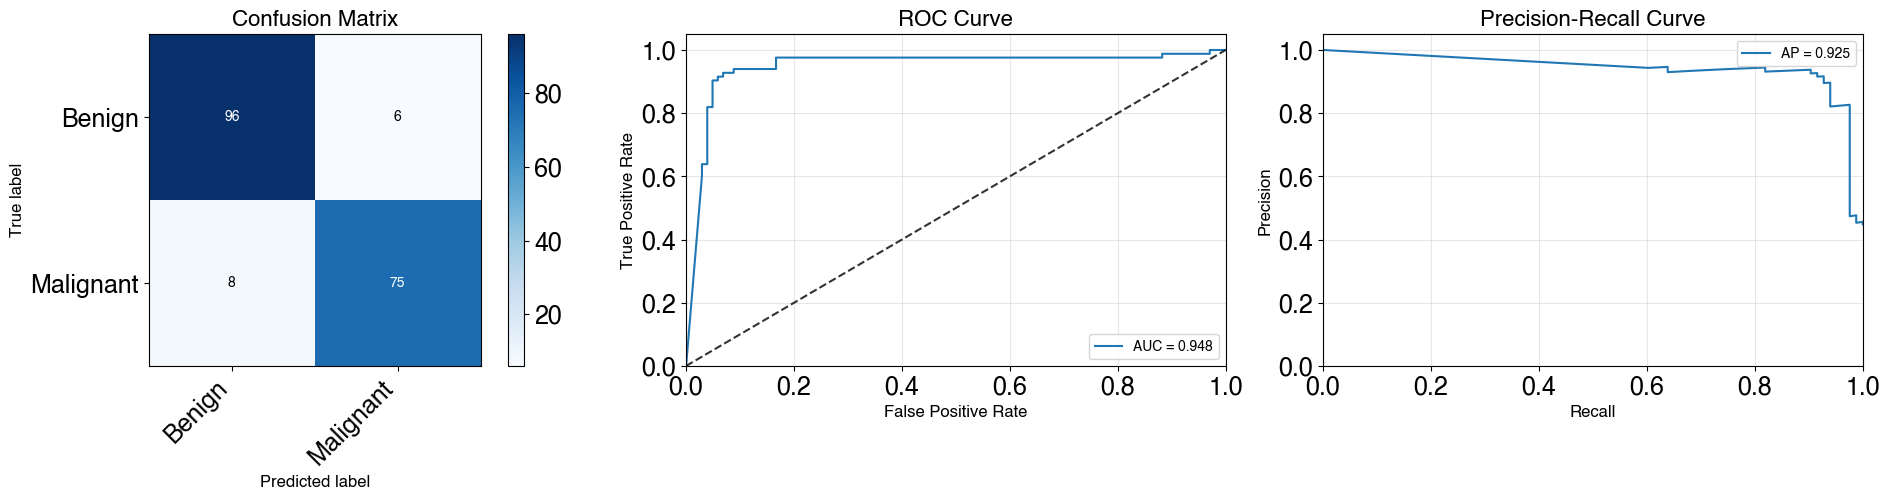


Model Evaluation Metrics:
Confusion Matrix:
[[96  6]
 [ 8 75]]
Accuracy: 0.9243
Precision: 0.9259
Recall: 0.9036
F1 Score: 0.9146
AUC-ROC: 0.9485
AUC-PR: 0.9250


In [72]:
results = evaluate_model(
    model=final_model, 
    X_test=X_final_test, 
    y_test=y_final_test, 
    class_names=["Benign", "Malignant"],
    save_dir=fig_output_dir_p1, 
    figsize=(20, 5),
    base_filename="test_balanced"
)


## Desbalanceado

In[35]:

In [73]:
config_cell_diagnosis_imbalanced = DatasetConfig(
        data_dir=data_dir_p1,
        target_column="Diagnosis",
        split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
    )

In [74]:
loader_cell_diagnosis_imbalanced = DataLoader(config_cell_diagnosis_imbalanced)

In [75]:
loader_cell_diagnosis_imbalanced.load_data(
        dev_file="raw/cell_diagnosis_imbalanced_dev.csv",
        test_file='raw/cell_diagnosis_imbalanced_test.csv',
        splitted=False
    )

In [76]:
cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=False)

In [77]:
cell_diagnosis_imbalanced_train_outliers, cell_diagnosis_imbalanced_valid_outliers = train_valid_split(
    cell_diagnosis_imbalanced_dev_outliers, test_size=0.2, random_state=12
)

In [78]:
analyze_categorical_variables(cell_diagnosis_imbalanced_train_outliers, ["CellType", "GeneticMutation",'Diagnosis']);

Categorical variables distribution:

CellType distribution:


CellType  Count  Percentage (%)
0         ???    287           34.70
1    Epthlial    283           34.22
2  Mesnchymal    257           31.08


GeneticMutation distribution:


GeneticMutation  Count  Percentage (%)
0          Presnt    506            51.9
1           Absnt    469            48.1


Diagnosis distribution:


Diagnosis  Count  Percentage (%)
0        0.0    732           75.08
1        1.0    243           24.92

In[36]:

In [79]:
analyze_null_values(
    [cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers],
    ["conjunto de desarrollo imbalanceado", "conjunto de prueba imbalanceado"]
);

Valores nulos en conjunto de desarrollo imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                236           19.38
1             CellShape                237           19.46
2        NucleusDensity                220           18.06
3      ChromatinTexture                212           17.41
4         CytoplasmSize                245           20.11
5          CellAdhesion                214           17.57
6           MitosisRate                240           19.70
7       NuclearMembrane                225           18.47
8          GrowthFactor                230           18.88
9      OxygenSaturation                220           18.06
10      Vascularization                230           18.88
11  InflammationMarkers                219           17.98
12            Diagnosis                  0            0.00
13             CellType                184           15.11
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo      1126           92.45
1           Muestras sin valores nulos        92            7.55
2                    Total de muestras      1218          100.00



Valores nulos en conjunto de prueba imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 25           18.38
1             CellShape                 31           22.79
2        NucleusDensity                 28           20.59
3      ChromatinTexture                 25           18.38
4         CytoplasmSize                 23           16.91
5          CellAdhesion                 19           13.97
6           MitosisRate                 31           22.79
7       NuclearMembrane                 16           11.76
8          GrowthFactor                 32           23.53
9      OxygenSaturation                 25           18.38
10      Vascularization                 31           22.79
11  InflammationMarkers                 28           20.59
12            Diagnosis                  0            0.00
13             CellType                 21           15.44
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       127           93.38
1           Muestras sin valores nulos         9            6.62
2                    Total de muestras       136          100.00

Apply the imputation process

In [80]:
cell_diagnosis_imbalanced_train_outliers, cell_diagnosis_imbalanced_valid_outliers, cell_diagnosis_imbalanced_test_outliers = impute_missing_values(
    cell_diagnosis_imbalanced_train_outliers,
    cell_diagnosis_imbalanced_valid_outliers,
    cell_diagnosis_imbalanced_test_outliers,
    knn_neighbors=8,
    knn_weights='distance'
)

Missing values before imputation:
Train: 2313 missing values
Valid: 599 missing values
Test: 335 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


In[38]:

In [ ]:
loader_cell_diagnosis_imbalanced.update(df_train=cell_diagnosis_imbalanced_train_outliers, df_valid=cell_diagnosis_imbalanced_valid_outliers, df_test=cell_diagnosis_imbalanced_test_outliers);

In [82]:
df_preprocessed_cell_diagnosis_imbalanced_test_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_imbalanced_test.csv"
df_preprocessed_cell_diagnosis_imbalanced_train_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_imbalanced_train.csv"
df_preprocessed_cell_diagnosis_imbalanced_valid_dir = data_dir / "p1" / "preprocessed" / "cell_diagnosis_imbalanced_valid.csv"

In [83]:
loader_cell_diagnosis_imbalanced.save_processed_data(df_train_dir=df_preprocessed_cell_diagnosis_imbalanced_train_dir, df_valid_dir=df_preprocessed_cell_diagnosis_imbalanced_valid_dir, df_test_dir=df_preprocessed_cell_diagnosis_imbalanced_test_dir)

Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_imbalanced_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_imbalanced_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/preprocessed/cell_diagnosis_imbalanced_test.csv


In[39]:

In [84]:
loader_cell_diagnosis_imbalanced.load_data(
        train_file="preprocessed/cell_diagnosis_imbalanced_train.csv",
        valid_file='preprocessed/cell_diagnosis_imbalanced_valid.csv',
        test_file='preprocessed/cell_diagnosis_imbalanced_test.csv',
        splitted=True
    )

In [85]:
cell_diagnosis_imbalanced_train_outliers, cell_diagnosis_imbalanced_valid_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=True)

In[40]:

In [86]:
print_numerical_features_range(cell_diagnosis_imbalanced_valid_outliers);

Rango de cada feature numérica (13 features):


In[41]:

Saved figure to figures/numerical_distributions_outliers.png


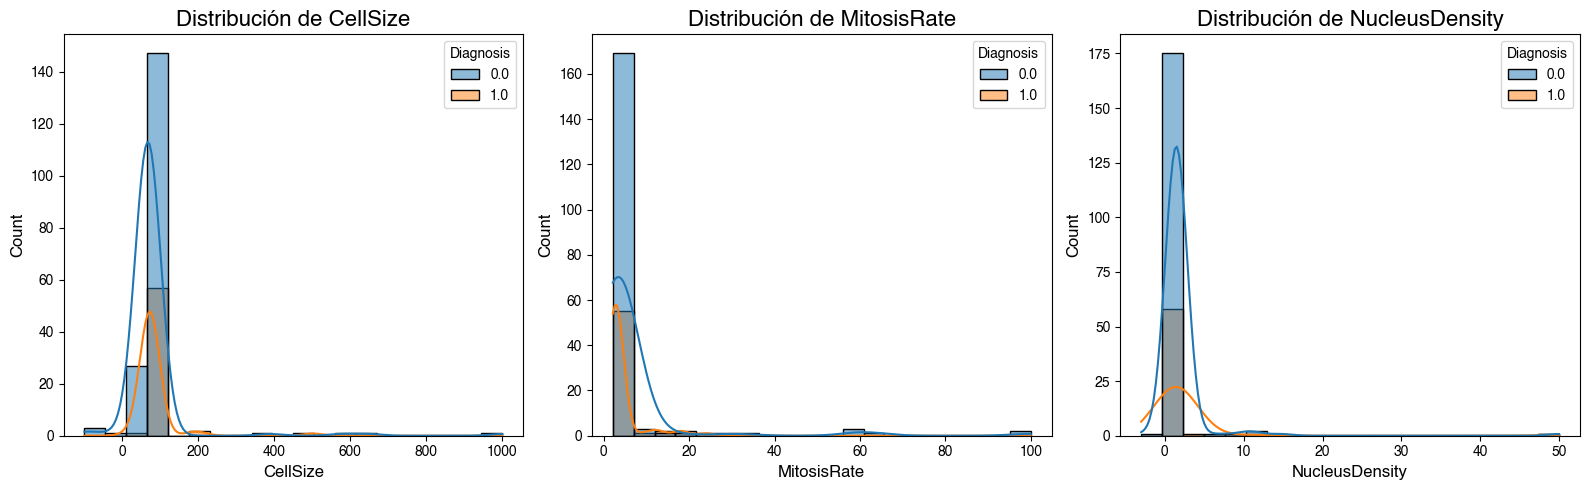

In [87]:
fig = plot_numerical_distributions(cell_diagnosis_imbalanced_valid_outliers, numerical_cols_cell_diagnosis_balanced_train_outliers, "Diagnosis",features_to_plot=FEATURES_TO_PLOT,figsize=(16,5),output_dir="figures",filename="numerical_distributions_outliers.png")
plt.show()

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_imbalanced_outliers.png


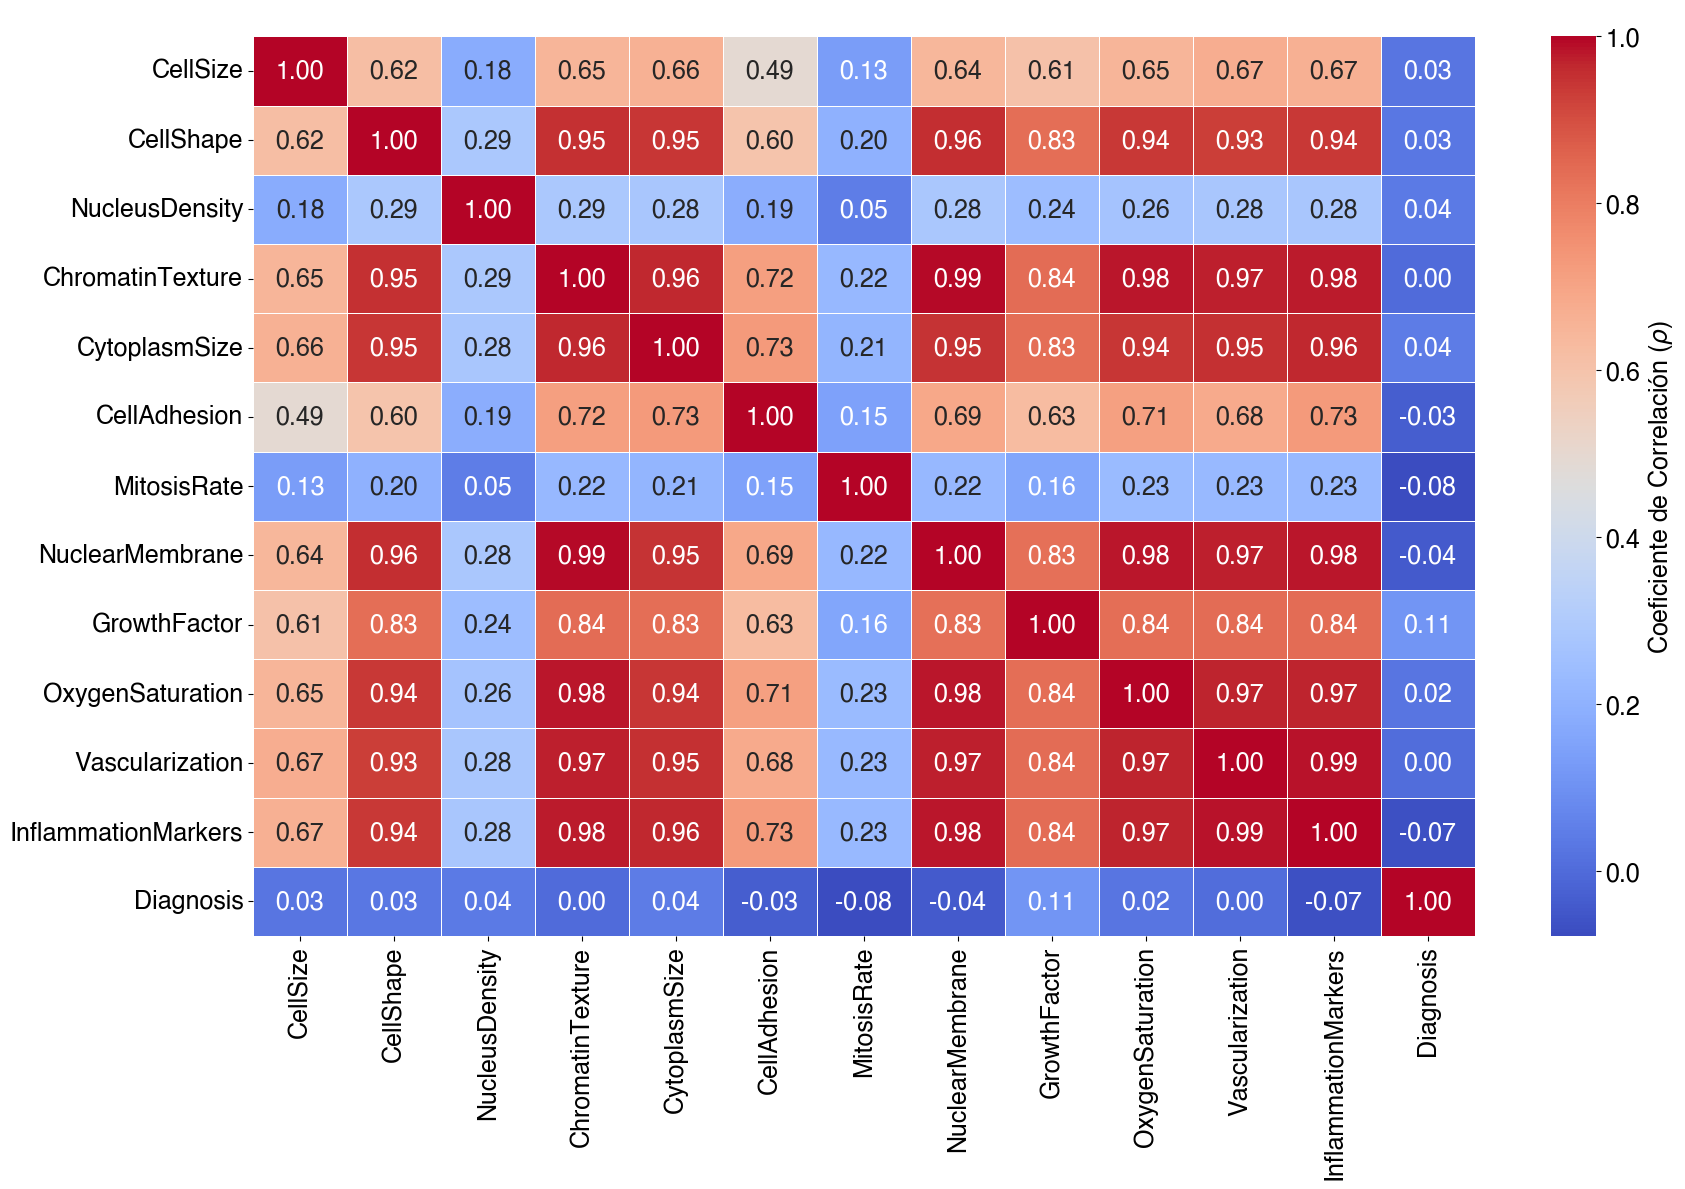

In [88]:
fig = plot_correlation_heatmap(
    cell_diagnosis_imbalanced_valid_outliers, 
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_imbalanced_outliers.png",
    title=' ',
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18,12),
)
plt.show()

In[42]:

Gráfico guardado en: ./figures/p1/boxplots_analysis_imbalanced_outliers.png


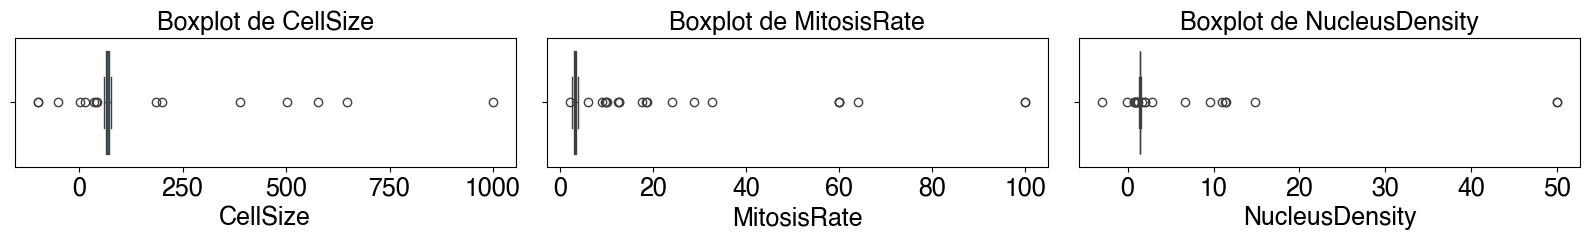

In [89]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_imbalanced_valid_outliers, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename='boxplots_analysis_imbalanced_outliers.png',
    show_plots=True
)

In [90]:
# Verificamos que las clases estén presentes
print(f"Clases en train: {cell_diagnosis_imbalanced_dev_outliers['Diagnosis'].unique()}")


Clases en train: [0. 1.]


In[43]:

In [91]:
cell_diagnosis_imbalanced_train, params = replace_outliers_iqr(cell_diagnosis_imbalanced_train_outliers, method='winsorize', return_params=True,target_column="Diagnosis")
cell_diagnosis_imbalanced_valid = replace_outliers_iqr(cell_diagnosis_imbalanced_valid_outliers, method='winsorize', params=params,target_column="Diagnosis")
cell_diagnosis_imbalanced_test = replace_outliers_iqr(cell_diagnosis_imbalanced_test_outliers, method='winsorize', params=params,target_column="Diagnosis")

In [92]:
# Concatenamos los conjuntos de train y valid para crear el conjunto de desarrollo (dev)
# Aseguramos que se preserven todas las columnas, incluyendo las clases (como 'Diagnosis')
# El parámetro ignore_index=False mantiene los índices originales para evitar duplicados
# El parámetro sort=False mantiene el orden original de las columnas
cell_diagnosis_imbalanced_dev = pd.concat([cell_diagnosis_imbalanced_train, cell_diagnosis_imbalanced_valid], 
                                         ignore_index=False, 
                                         sort=False)

# Verificamos que las clases estén presentes
print(f"Clases en train: {cell_diagnosis_imbalanced_train['Diagnosis'].unique()}")
print(f"Clases en valid: {cell_diagnosis_imbalanced_valid['Diagnosis'].unique()}")
print(f"Clases en dev: {cell_diagnosis_imbalanced_dev['Diagnosis'].unique()}")

Clases en train: [1. 0.]
Clases en valid: [0. 1.]
Clases en dev: [1. 0.]


In [93]:
loader_cell_diagnosis_imbalanced.update(
    df_train=cell_diagnosis_imbalanced_train,
    df_valid=cell_diagnosis_imbalanced_valid,
    df_test=cell_diagnosis_imbalanced_test
)

In [94]:
df_cell_diagnosis_imbalanced_train_dir = data_dir / "p1" / "processed" / "cell_diagnosis_imbalanced_train.csv"
df_cell_diagnosis_imbalanced_valid_dir = data_dir / "p1" / "processed" / "cell_diagnosis_imbalanced_valid.csv"
df_cell_diagnosis_imbalanced_test_dir = data_dir / "p1" / "processed" / "cell_diagnosis_imbalanced_test.csv"
df_cell_diagnosis_imbalanced_dev_dir = data_dir / "p1" / "processed" / "cell_diagnosis_imbalanced_dev.csv"

In [95]:
pd.DataFrame(cell_diagnosis_imbalanced_dev).to_csv(df_cell_diagnosis_imbalanced_dev_dir, index=False)

In [96]:
loader_cell_diagnosis_imbalanced.save_processed_data(
    df_train_dir=df_cell_diagnosis_imbalanced_train_dir,
    df_valid_dir=df_cell_diagnosis_imbalanced_valid_dir,
    df_test_dir=df_cell_diagnosis_imbalanced_test_dir,
    df_dev_dir=df_cell_diagnosis_imbalanced_dev_dir
)

Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_imbalanced_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_imbalanced_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_imbalanced_test.csv
Development data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p1/processed/cell_diagnosis_imbalanced_dev.csv


In[44]:

In [97]:
loader_cell_diagnosis_imbalanced.load_data(
    train_file="processed/cell_diagnosis_imbalanced_train.csv",
    valid_file='processed/cell_diagnosis_imbalanced_valid.csv',
    test_file='processed/cell_diagnosis_imbalanced_test.csv',
    splitted=True
)

In [98]:
cell_diagnosis_imbalanced_train, cell_diagnosis_imbalanced_valid, cell_diagnosis_imbalanced_test = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=True)

In[45]:

In [99]:
print_numerical_features_range(cell_diagnosis_imbalanced_valid);

Rango de cada feature numérica (13 features):


In[46]:

Saved figure to ./figures/p1/correlation_heatmap_numerical_features_imbalanced.png


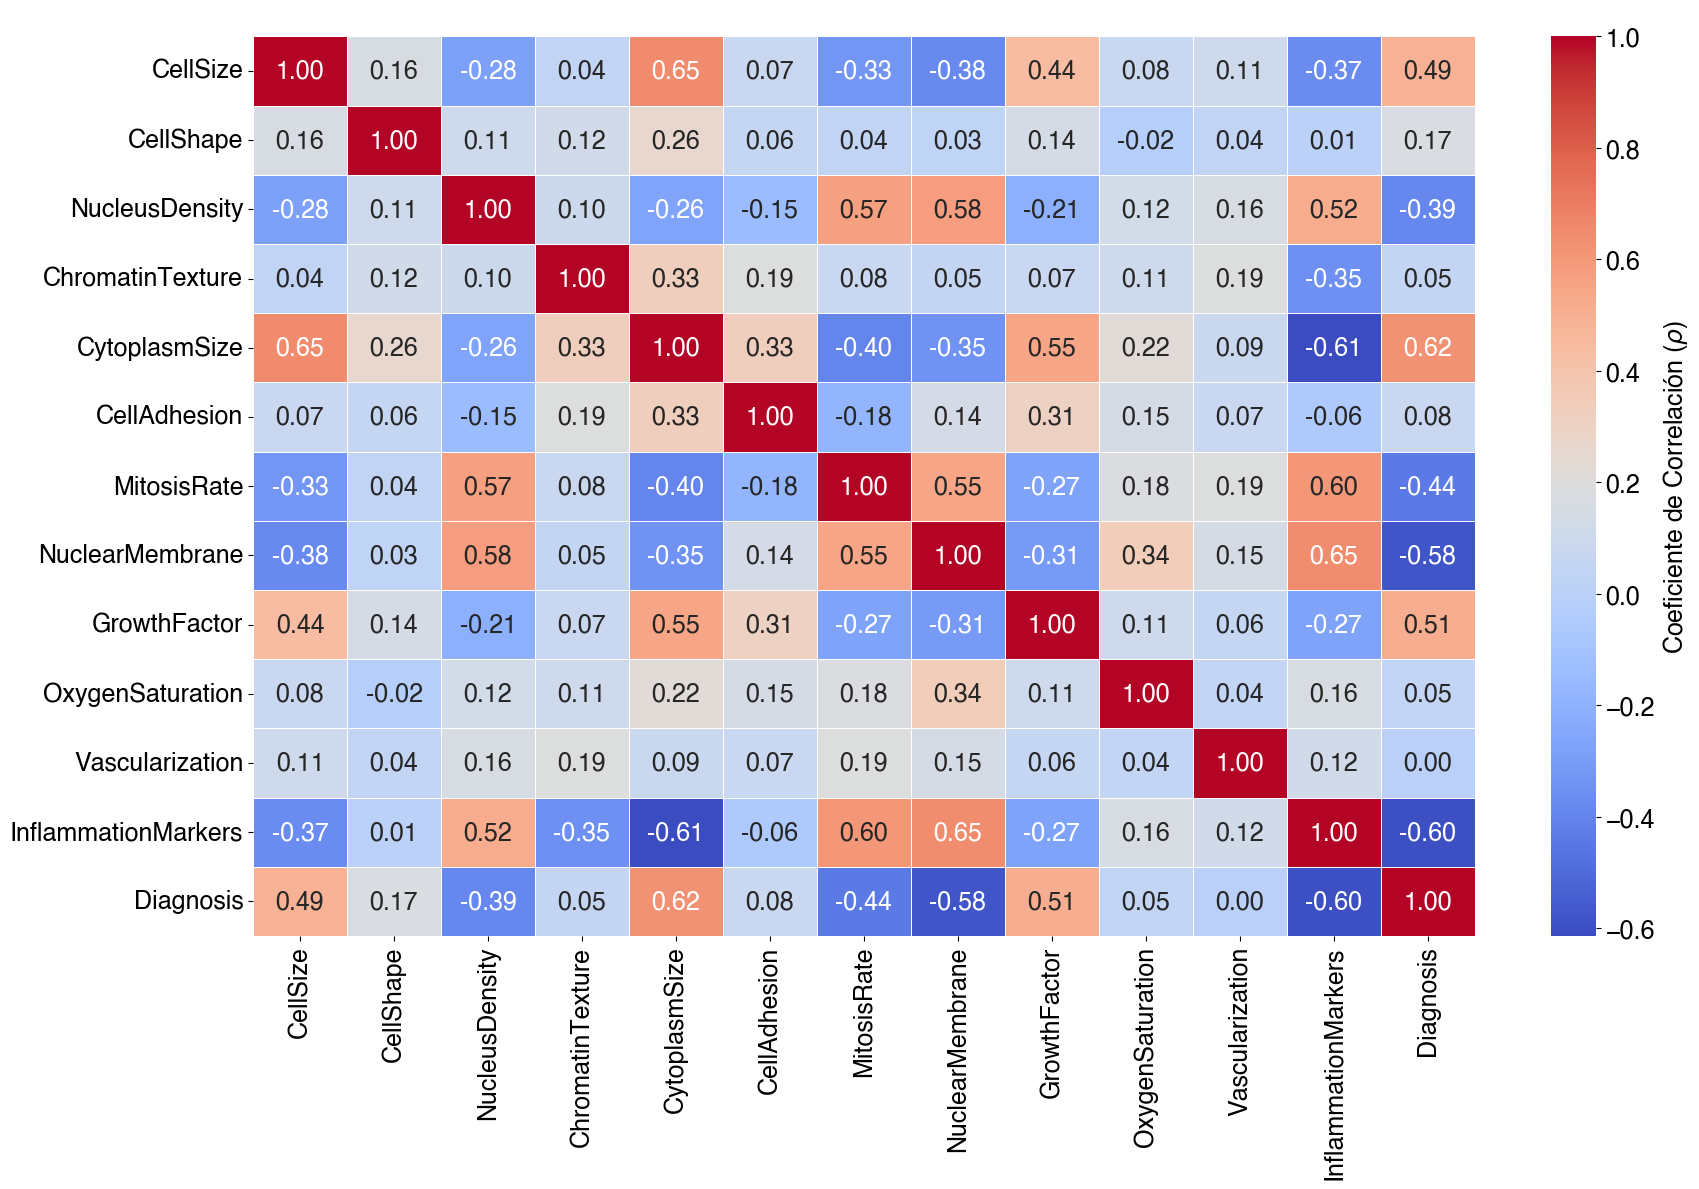

In [100]:
fig = plot_correlation_heatmap(
    cell_diagnosis_imbalanced_valid, 
    numerical_cols_cell_diagnosis_balanced_train_outliers + ["Diagnosis"],
    output_dir=fig_output_dir_p1,
    filename="correlation_heatmap_numerical_features_imbalanced.png",
    title=' ',
    label_fontsize=18,
    title_fontsize=18,
    tick_fontsize=18,
    cbar_fontsize=18,
    annot_fontsize=18,
    figsize=(18,12),
)
plt.show()

In[47]:

Gráfico guardado en: ./figures/p1/boxplots_analysis_imbalanced.png


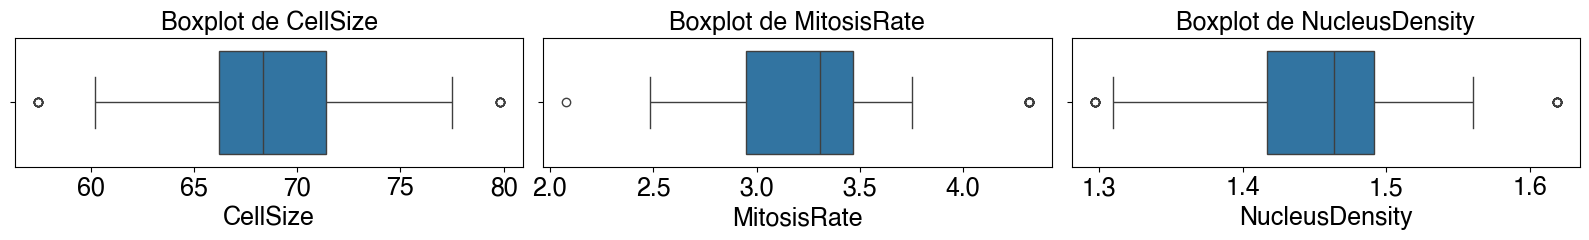

In [101]:
fig = plot_outliers_analysis(
    df=cell_diagnosis_imbalanced_valid, 
    features_to_plot=FEATURES_TO_PLOT,
    save_dir=fig_output_dir_p1,
    figsize=(16, 5),
    filename='boxplots_analysis_imbalanced.png',
    show_plots=True
)

### Punto 1.4 y 1.5

In[ ]:

In [102]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [103]:
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig
from models.logistic_regression_with_cost import CostSensitiveLogisticRegression, CostSensitiveLogisticRegressionConfig
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.rebalancing import (
    RandomUnderSampler, 
    RandomOverSampler, 
    SMOTE, 
    SMOTEConfig,
    RebalancingConfig
)
from utils.utils import evaluate_model
from utils.visuals import plot_roc_curve, plot_precision_recall_curve

In [104]:

def calculate_class_weights(y):
    """
    Calculate class weights for cost-sensitive learning according to the formula C = π2/π1
    where π1 is the prior probability of the minority class and π2 is the prior probability 
    of the majority class.
    
    Parameters
    ----------
    y : np.ndarray
        Target vector with class labels
        
    Returns
    -------
    Dict[int, float]
        Dictionary mapping class labels to weights
    """
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)

    # Calculate class probabilities
    probs = counts / total

    # Find majority class and its probability
    majority_idx = np.argmax(counts)
    majority_class = classes[majority_idx]
    majority_prob = probs[majority_idx]

    # Initialize weights with 1.0 for all classes
    weights = {cls: 1.0 for cls in classes}

    # Apply weight C = π2/π1 only to minority classes
    for i, cls in enumerate(classes):
        if cls != majority_class:  # If it's a minority class
            weights[cls] = majority_prob / probs[i]
            
    # Log the weights for debugging
    print(f"Class weights: {weights}")
    print(f"Class probabilities: {dict(zip(classes, probs))}")
    
    return weights

Configuración del dataset

In [105]:
dataset_config = DatasetConfig(
    data_dir=data_dir,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)

Parámetros de entrenamiento

In [106]:
lambda_reg = 0
lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=lambda_reg,
    random_state=42,
    verbose=True
)

Carga de datos

In [107]:
df_train, df_test = cell_diagnosis_imbalanced_dev, cell_diagnosis_imbalanced_test
print(f"Development data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Development data shape: (1218, 15)
Test data shape: (136, 15)


Estadísticas del dataset

In [108]:
analyze_categorical_variables(cell_diagnosis_imbalanced_train,['Diagnosis']);

Categorical variables distribution:

Diagnosis distribution:


Diagnosis  Count  Percentage (%)
0        0.0    732           75.08
1        1.0    243           24.92

Preprocesamiento de datos

In [109]:
cell_diagnosis_imbalanced_dev = cell_diagnosis_imbalanced_dev.reset_index(drop=True)
cell_diagnosis_imbalanced_valid = cell_diagnosis_imbalanced_valid.reset_index(drop=True)
cell_diagnosis_imbalanced_train = cell_diagnosis_imbalanced_train.reset_index(drop=True)

X_train, X_val, y_train, y_val = cell_diagnosis_imbalanced_train.drop(columns=["Diagnosis"]), cell_diagnosis_imbalanced_valid.drop(columns=["Diagnosis"]), cell_diagnosis_imbalanced_train["Diagnosis"], cell_diagnosis_imbalanced_valid["Diagnosis"]

# Categorical encoding
X_train = DataLoader.encode_categorical(X_train)
X_val = DataLoader.encode_categorical(X_val)

X_train, X_val, y_train, y_val = X_train.to_numpy(), X_val.to_numpy(), y_train.to_numpy(), y_val.to_numpy()

In [110]:
X_test, y_test = loader_cell_diagnosis.get_processed_test_data(
    return_numpy=True,
    encode_categorical=True,
    normalize=True
)

In [111]:
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 975 samples
Validation set: 243 samples
Test set: 185 samples


Nombre de las clases para las métricas

In [112]:
class_names = ["Benign", "Malignant"]

Diccionario para almacenar modelos y métricas

In [113]:
all_models = {}

1. Sin rebalanceo (baseline)

In [114]:

model_no_rebalancing = LogisticRegression(lr_config)
model_no_rebalancing.fit(X_train, y_train)

metrics_no_rebalancing = evaluate_model(
    model_no_rebalancing, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["No rebalancing"] = {
    "model": model_no_rebalancing,
    "metrics": metrics_no_rebalancing
}


Iteration 0, Cost: 5.738751
Converged at iteration 4 with cost 5.738751


2. Undersampling

In [115]:

undersampler = RandomUnderSampler(RebalancingConfig(random_state=42,sampling_strategy=0.5))
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
unique, counts = np.unique(y_train_under, return_counts=True)
print("Class distribution after undersampling:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

Class distribution after undersampling:
Class 0.0: 243 samples
Class 1.0: 243 samples


In [116]:
model_undersampling = LogisticRegression(lr_config)
model_undersampling.fit(X_train_under, y_train_under);

Iteration 0, Cost: 11.445007
Iteration 100, Cost: 6.158717
Iteration 200, Cost: 8.027444
Iteration 300, Cost: 1.265866
Iteration 400, Cost: 1.167385
Iteration 500, Cost: 1.060995
Iteration 600, Cost: 0.963593
Iteration 700, Cost: 0.882325
Converged at iteration 788 with cost 0.825081


In [117]:
metrics_undersampling = evaluate_model(
    model_undersampling, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Undersampling"] = {
    "model": model_undersampling,
    "metrics": metrics_undersampling
}


3. Oversampling via duplication

Estadísticas después del rebalanceo

In [ ]:

oversampler = RandomOverSampler(RebalancingConfig(random_state=42))
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
unique, counts = np.unique(y_train_over, return_counts=True)
print("Class distribution after oversampling:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

model_oversampling = LogisticRegression(lr_config)
model_oversampling.fit(X_train_over, y_train_over);

Class distribution after oversampling:
Class 0.0: 732 samples
Class 1.0: 732 samples
Iteration 0, Cost: 11.456457
Iteration 100, Cost: 6.345713
Iteration 200, Cost: 8.277720
Iteration 300, Cost: 1.301278
Iteration 400, Cost: 1.203683
Iteration 500, Cost: 1.107501
Iteration 600, Cost: 1.013444
Iteration 700, Cost: 0.923852
Iteration 800, Cost: 0.842762
Iteration 900, Cost: 8.668170
Iteration 999, Cost: 1.119921
Reached max iterations (1000) without converging.


In [119]:
metrics_oversampling = evaluate_model(
    model_oversampling, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Oversampling duplicate"] = {
    "model": model_oversampling,
    "metrics": metrics_oversampling
}

4. Oversampling via SMOTE

In [120]:

smote = SMOTE(SMOTEConfig(random_state=42, k_neighbors=5))
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_smote, return_counts=True)
print("Class distribution after SMOTE:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

model_smote = LogisticRegression(lr_config)
model_smote.fit(X_train_smote, y_train_smote);

Class distribution after SMOTE:
Class 0.0: 732 samples
Class 1.0: 732 samples
Iteration 0, Cost: 11.455805
Iteration 100, Cost: 5.929299
Iteration 200, Cost: 8.058352
Iteration 300, Cost: 1.221627
Iteration 400, Cost: 1.138212
Iteration 500, Cost: 1.059986
Iteration 600, Cost: 0.984197
Iteration 700, Cost: 0.909044
Iteration 800, Cost: 0.834249
Iteration 900, Cost: 0.762778
Iteration 999, Cost: 9.375122
Reached max iterations (1000) without converging.


In [121]:
metrics_smote = evaluate_model(
    model_smote, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)
all_models["Oversampling SMOTE"] = {
    "model": model_smote,
    "metrics": metrics_smote
}

5. Cost reweighting

In [122]:
print("\n===== Training model with Cost reweighting =====")
class_weights = calculate_class_weights(y_train)
print(f"Class weights: {class_weights}")

cost_config = CostSensitiveLogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    lambda_reg=lambda_reg,
    random_state=42,
    verbose=True,
    class_weight=class_weights
)
model_cost = CostSensitiveLogisticRegression(cost_config)
model_cost.fit(X_train, y_train);


===== Training model with Cost reweighting =====
Class weights: {np.float64(0.0): 1.0, np.float64(1.0): np.float64(3.0123456790123457)}
Class probabilities: {np.float64(0.0): np.float64(0.7507692307692307), np.float64(1.0): np.float64(0.24923076923076923)}
Class weights: {np.float64(0.0): 1.0, np.float64(1.0): np.float64(3.0123456790123457)}
Iteration 0, Cost: 17.287100
Converged at iteration 1 with cost 17.287100


In [123]:
metrics_cost = evaluate_model(
    model_cost, X_val, y_val, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=False
)

all_models["Cost re-weighting"] = {
    "model": model_cost,
    "metrics": metrics_cost
}

In [124]:
from utils.utils import evaluate_all_models

Evaluar en conjunto de validación

Evaluating No rebalancing on validation set
Evaluating Undersampling on validation set
Evaluating Oversampling duplicate on validation set
Evaluating Oversampling SMOTE on validation set
Evaluating Cost re-weighting on validation set


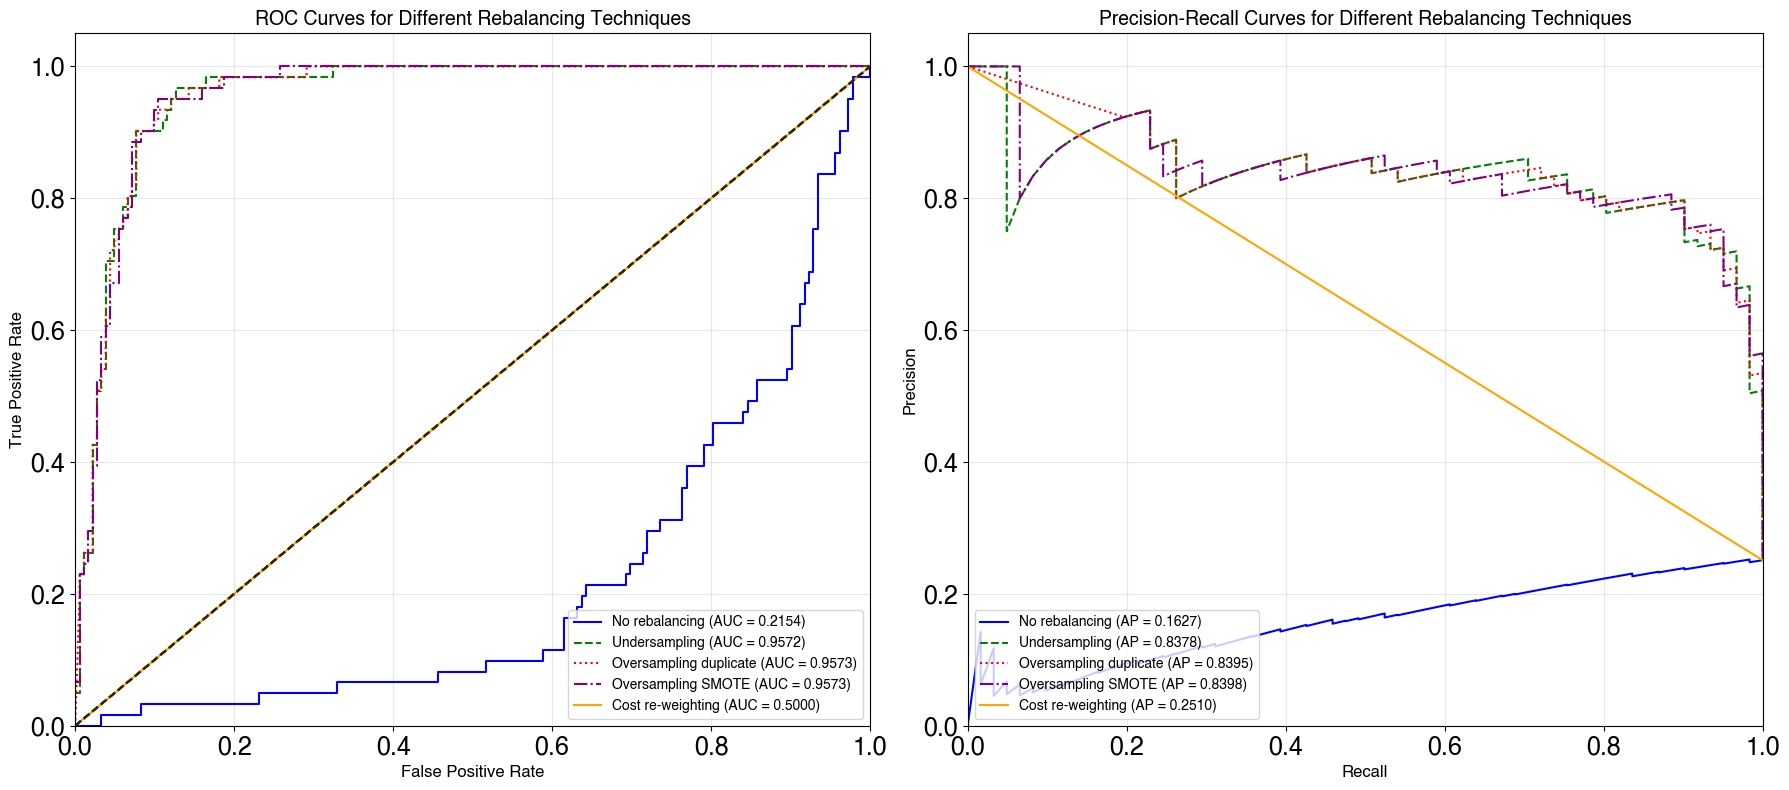

In [126]:
val_metrics_df, val_metrics = evaluate_all_models(
    all_models, 
    X_val, 
    y_val, 
    class_names, 
    fig_output_dir_p1,
    prefix="validation",
    subplots=True,
    show_plot=True,
    individual_plots=False
)

Evaluar en conjunto de prueba

Evaluating No rebalancing on test set
Evaluating Undersampling on test set
Evaluating Oversampling duplicate on test set
Evaluating Oversampling SMOTE on test set
Evaluating Cost re-weighting on test set


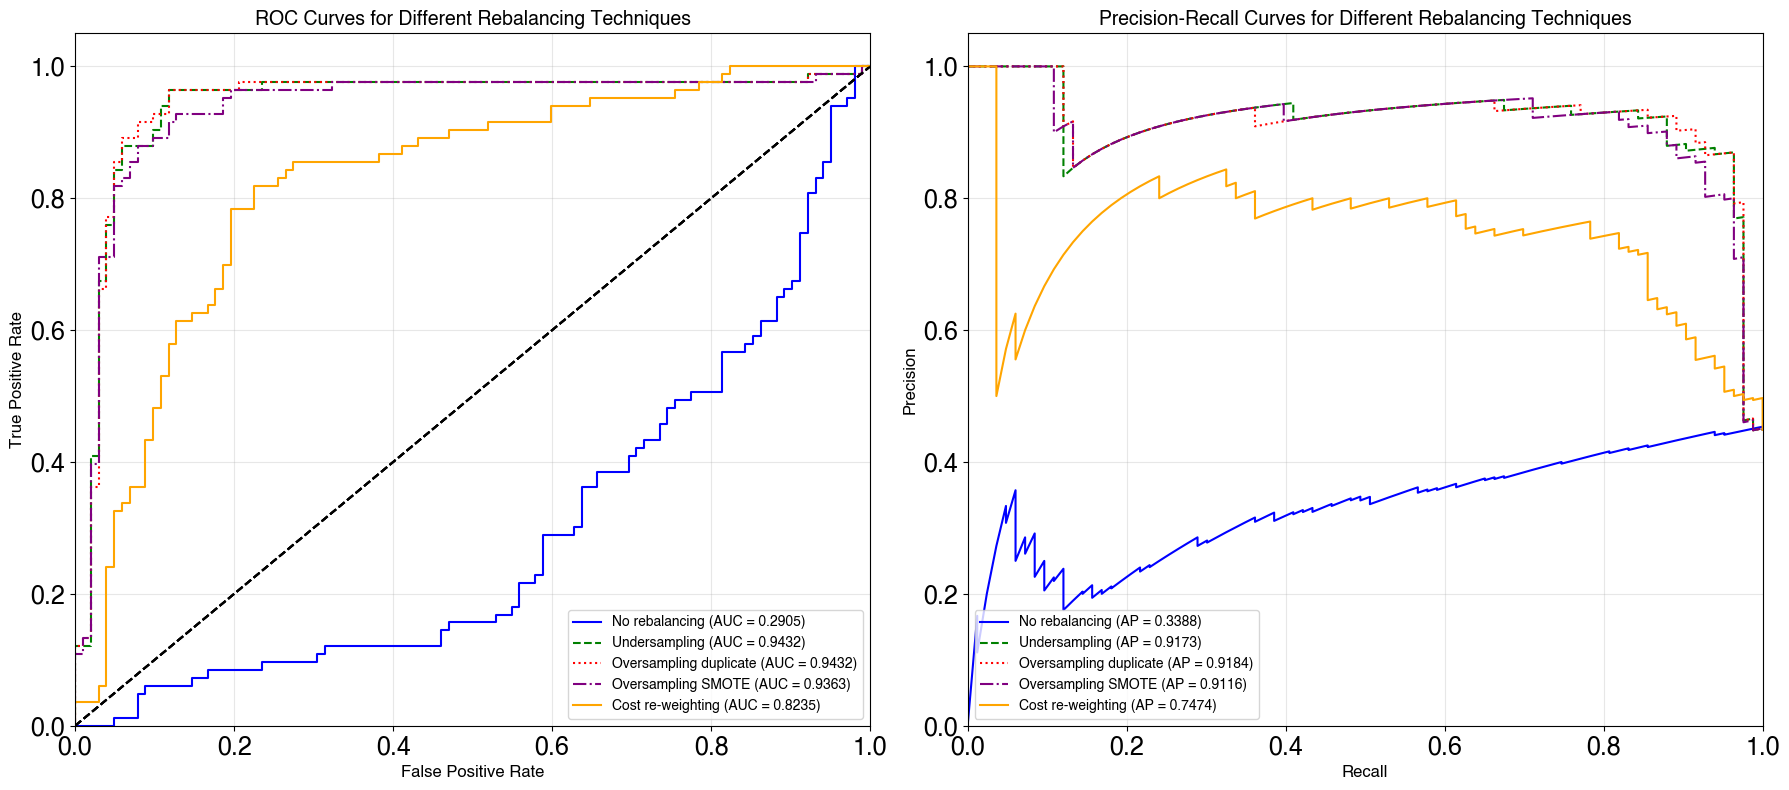

In [128]:
test_metrics_df, test_metrics = evaluate_all_models(
    all_models, 
    X_test, 
    y_test, 
    class_names, 
    fig_output_dir_p1,
    subplots=True,
    prefix="test",
    show_plot=True,
    individual_plots=False
)

In [322]:
print("\n===== Validation Metrics Summary =====")
print(val_metrics_df.to_string(index=False))


===== Validation Metrics Summary =====
                 Model Accuracy Precision Recall F-Score AUC-ROC AUC-PR
        No rebalancing   0.7490    0.0000 0.0000  0.0000  0.2154 0.1627
         Undersampling   0.9136    0.7857 0.9016  0.8397  0.9572 0.8378
Oversampling duplicate   0.9095    0.7746 0.9016  0.8333  0.9573 0.8395
    Oversampling SMOTE   0.7531    1.0000 0.0164  0.0323  0.9573 0.8398
     Cost re-weighting   0.2510    0.2510 1.0000  0.4013  0.5000 0.2510


In [323]:
print("\n===== Test Metrics Summary =====")
print(test_metrics_df.to_string(index=False))


===== Test Metrics Summary =====
                 Model Accuracy Precision Recall F-Score AUC-ROC AUC-PR
        No rebalancing   0.3459    0.3304 0.4458  0.3795  0.2905 0.3388
         Undersampling   0.8973    0.8902 0.8795  0.8848  0.9432 0.9173
Oversampling duplicate   0.9081    0.9024 0.8916  0.8970  0.9432 0.9184
    Oversampling SMOTE   0.8973    0.8810 0.8916  0.8862  0.9363 0.9116
     Cost re-weighting   0.7622    0.7468 0.7108  0.7284  0.8235 0.7474


### Punto 1.6

Utilizaria el modelo de SMOTE PORQUE TATARARARTATAR ............................... ENTRENAR CON DEV ENTERO

# Punto 2

WAR_class_dev.csv - Información básica:
Número de filas: 6782
Número de columnas: 6

Primeras filas del dataset:


poss           mp  raptor_total  war_total  pace_impact  war_class
0  2283.468774   826.890427     -3.369325  -0.006893     0.472195          2
1  1185.081598   567.265296     -5.389056  -0.615802     1.567405          2
2  5272.362761  2403.044668      7.084319  11.688727    -0.534305          3
3  7594.083790  3709.114977      5.532538  14.739138    -0.710111          3
4  8479.653469  3803.026613      5.089253  15.920002    -0.699135          3


Resumen estadístico:


poss           mp  raptor_total    war_total  pace_impact  \
count  6782.000000  6782.000000   6782.000000  6782.000000  6782.000000   
mean   3639.756160  1811.567736     -1.484226     2.772859     0.091128   
std    2097.793568  1039.122355      4.667840     5.239333     0.650618   
min    -414.390684  -235.333650    -43.449330    -6.589665    -6.935191   
25%    1913.845719   956.592966     -5.271681    -1.656335    -0.278206   
50%    3621.170163  1801.519616     -1.459043     0.490083     0.022291   
75%    5377.166126  2670.373141      2.201138     6.605975     0.389032   
max    9329.401575  4264.461247     32.904816    28.762877    11.193450   

         war_class  
count  6782.000000  
mean      2.031702  
std       0.793182  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       3.000000  
max       3.000000

Valores nulos en conjunto de desarrollo WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      6782           100.0
2                    Total de muestras      6782           100.0



Valores nulos en conjunto de prueba WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      1696           100.0
2                    Total de muestras      1696           100.0



Número de filas duplicadas en WAR_class_dev: 0
Categorical variables distribution:

war_class distribution:


war_class  Count  Percentage (%)
0          2   2509           36.99
1          3   2244           33.09
2          1   2029           29.92

Saved figure to ./figures/p2/numerical_distributions_war_class.png


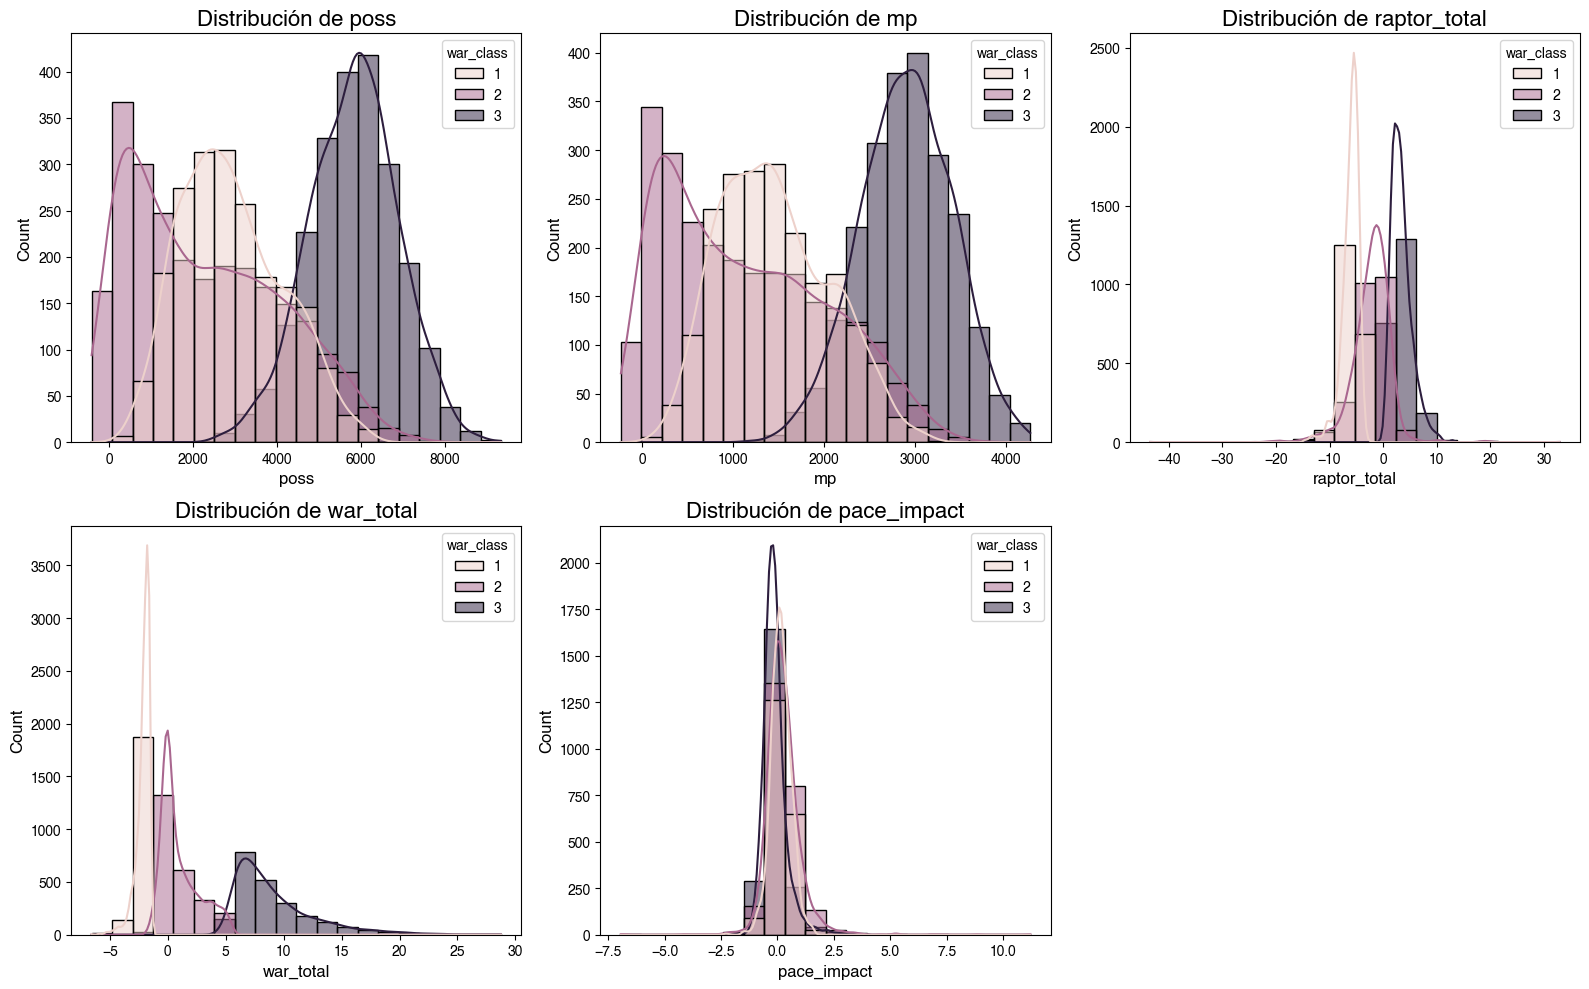

Saved figure to ./figures/p2/correlation_heatmap_war_class.png


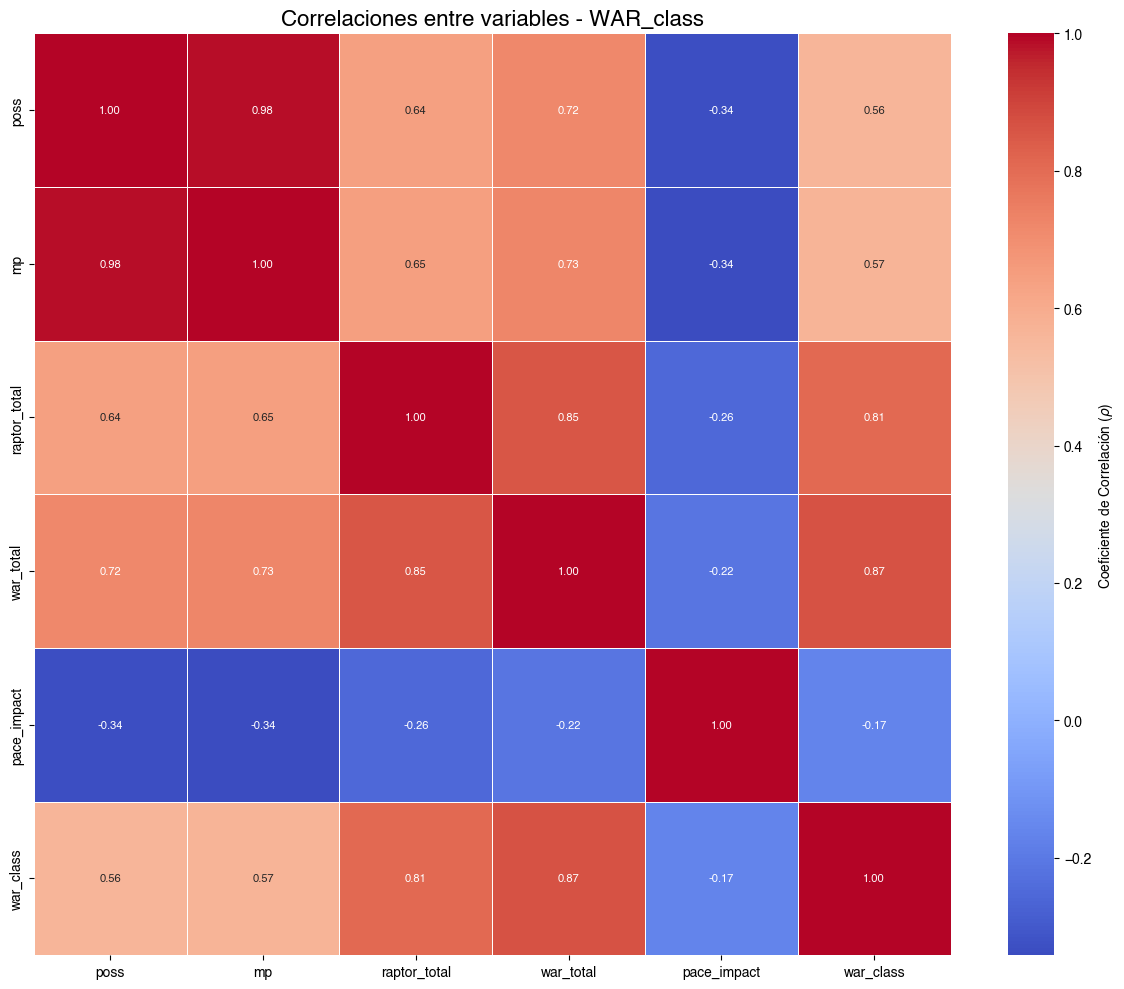

Valores nulos en conjunto de entrenamiento:
0
Valores nulos en conjunto de validación:
0
Training data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p2/preprocessed/WAR_class_train.csv
Validation data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p2/preprocessed/WAR_class_valid.csv
Test data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p2/preprocessed/WAR_class_test.csv
Development data saved to /Users/juanfra/Documents/Facultad/3er año - 1er Cuatri/Aprendizaje Automatico/TPs/tp2-machine-learning /data/p2/preprocessed/WAR_class_dev.csv

RESUMEN DEL ANÁLISIS EXPLORATORIO - WAR_class:
Número total de muestras en desarrollo: 6782
Número total de muestras en test: 1696
Número de features: 5

Distribución de clases:
  Clase 2: 2509 muestras (36.99%)
  Clase 3: 2244 muestras

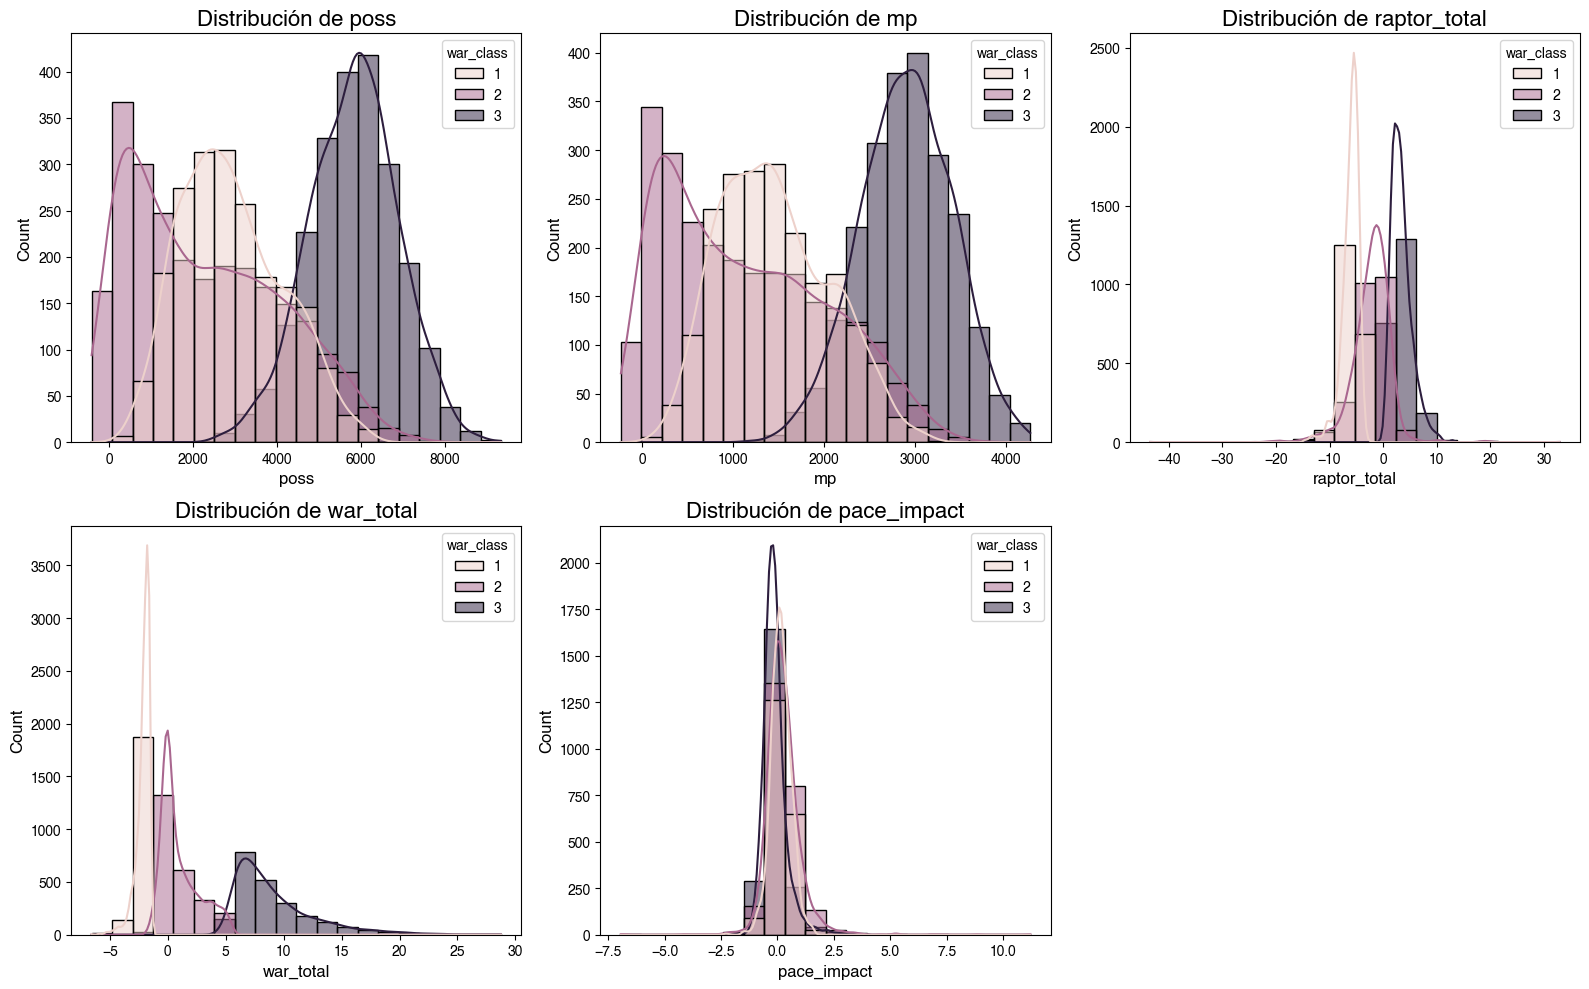

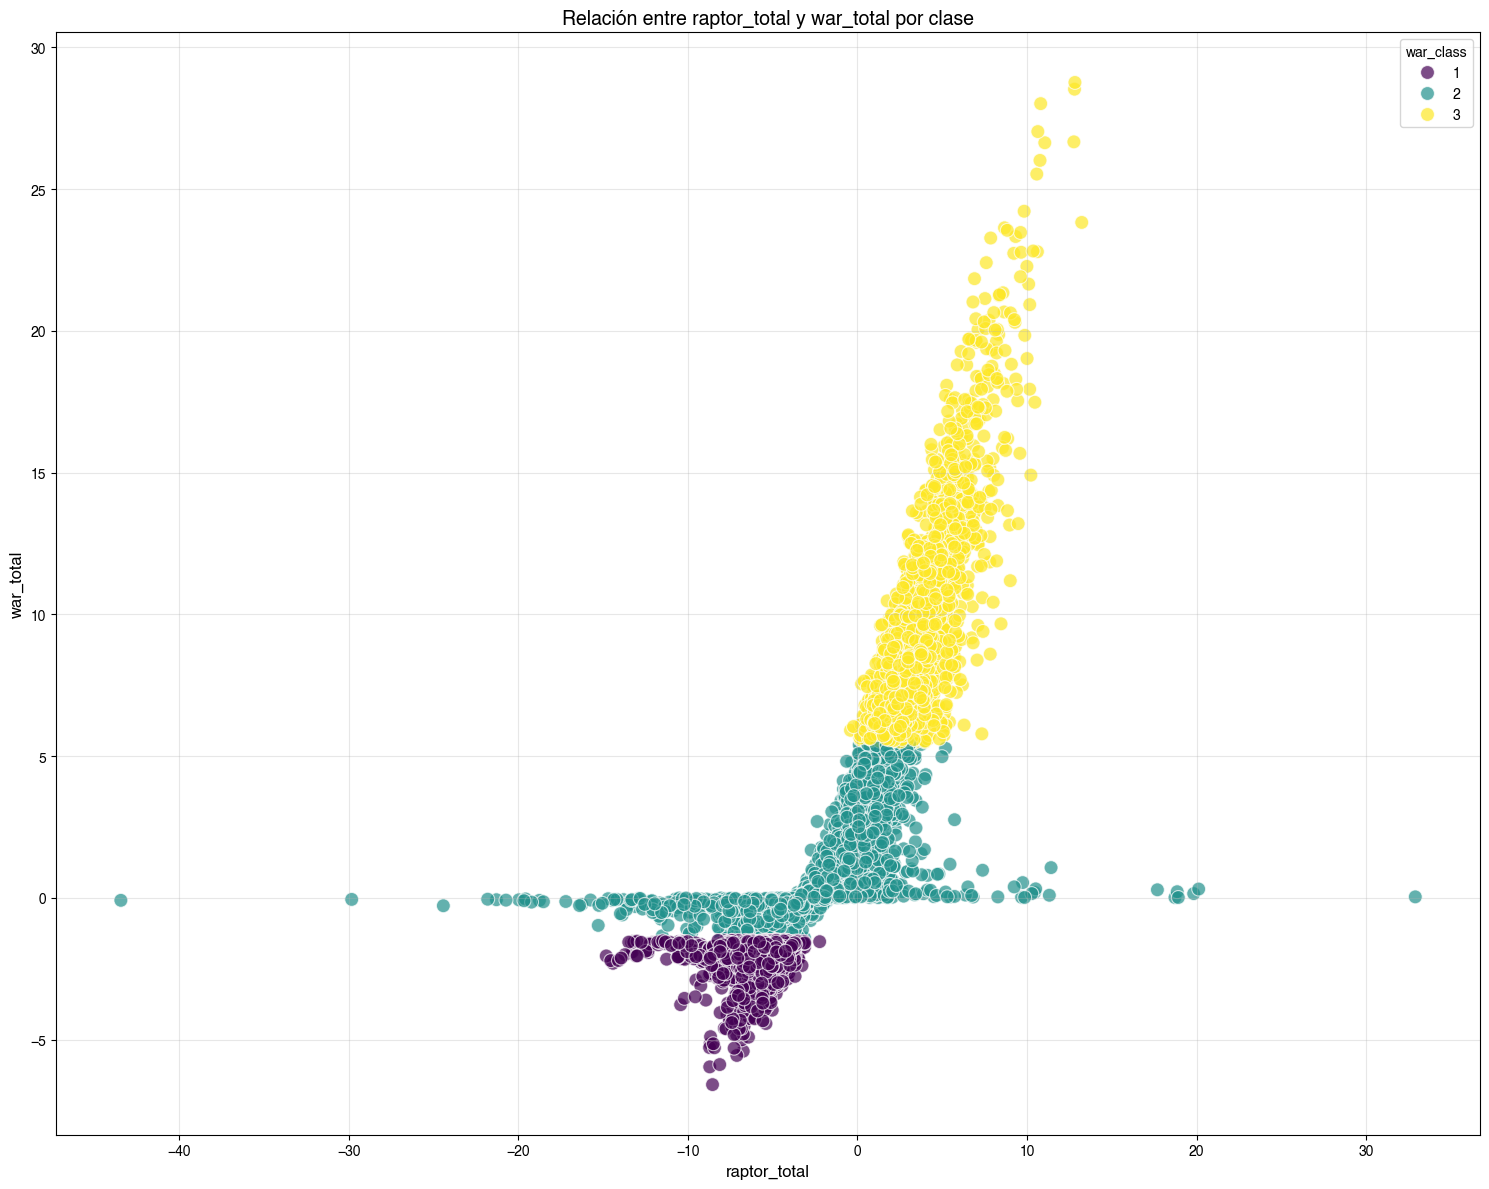

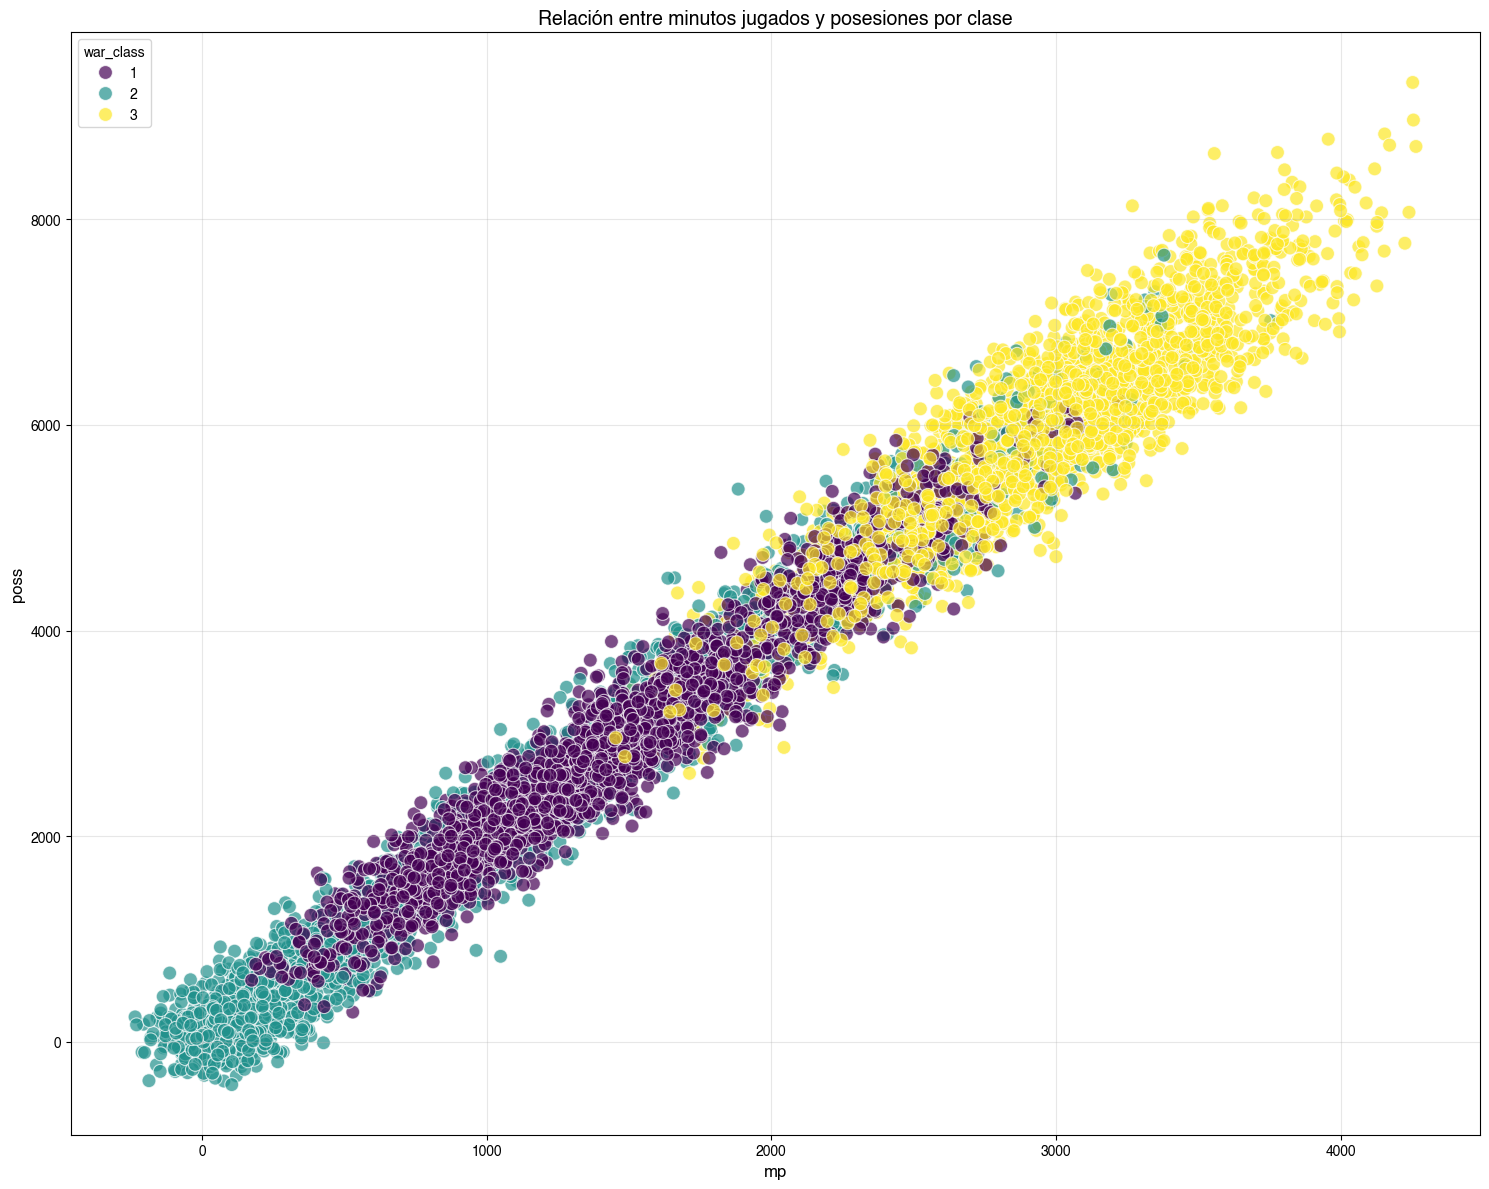

In [324]:


fig_output_dir_p2 = "./figures/p2"
os.makedirs(fig_output_dir_p2, exist_ok=True)


# In[151]:


data_dir_p2 = data_dir / "p2"


# In[152]:


config_war_class = DatasetConfig(
    data_dir=data_dir_p2,
    target_column="war_class",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)


# In[153]:


loader_war_class = DataLoader(config_war_class)


# In[154]:


loader_war_class.load_data(
    dev_file="raw/WAR_class_dev.csv",
    test_file='raw/WAR_class_test.csv',
    splitted=False
)


# In[155]:


war_class_dev, war_class_test = loader_war_class.get_pandas_data(splitted=False)


# In[156]:


# Verificar información básica del dataset
print("WAR_class_dev.csv - Información básica:")
print(f"Número de filas: {war_class_dev.shape[0]}")
print(f"Número de columnas: {war_class_dev.shape[1]}")
print("\nPrimeras filas del dataset:")
display(war_class_dev.head())
print("\nResumen estadístico:")
display(war_class_dev.describe())


# In[157]:


# Análisis de valores nulos
analyze_null_values(
    [war_class_dev, war_class_test],
    ["conjunto de desarrollo WAR_class", "conjunto de prueba WAR_class"]
);


# In[158]:


# Verificar si hay datos duplicados
duplicated_rows = war_class_dev.duplicated().sum()
print(f"Número de filas duplicadas en WAR_class_dev: {duplicated_rows}")


# In[159]:


# Análisis de la distribución de la variable objetivo (war_class)
analyze_categorical_variables(war_class_dev, ["war_class"]);


# In[160]:


# Obtener columnas numéricas (excluyendo la variable objetivo)
numerical_cols_war = war_class_dev.select_dtypes(include=['number']).columns.tolist()
numerical_cols_war = [col for col in numerical_cols_war if col != "war_class"]


# In[161]:


# Visualizar distribuciones de variables numéricas
fig = plot_numerical_distributions(
    war_class_dev, 
    numerical_cols=numerical_cols_war,
    target_column="war_class",
    output_dir=fig_output_dir_p2,
    filename='numerical_distributions_war_class.png',
    figsize=(16, 10)
)
plt.show()


# In[162]:


# Analizar correlaciones entre features
fig = plot_correlation_heatmap(
    war_class_dev, 
    numerical_cols_war + ["war_class"],
    output_dir=fig_output_dir_p2,
    filename="correlation_heatmap_war_class.png",
    title='Correlaciones entre variables - WAR_class',
    figsize=(12, 10)
)
plt.show()


# In[163]:


# Análisis de outliers en las variables numéricas
fig = plot_outliers_analysis(
    df=war_class_dev, 
    columns=numerical_cols_war,
    save_dir=fig_output_dir_p2,
    filename='boxplots_analysis_war_class.png',
    figsize=(16, 10),
    show_plots=True
)


# In[164]:


# Dividir el dataset en train y valid para preprocesamiento
war_class_train, war_class_valid = train_valid_split(
    war_class_dev, test_size=0.2, random_state=42
)


# In[165]:


# Revisar si existen valores nulos en los conjuntos divididos
print("Valores nulos en conjunto de entrenamiento:")
print(war_class_train.isnull().sum().sum())
print("Valores nulos en conjunto de validación:")
print(war_class_valid.isnull().sum().sum())


# In[166]:


# Preprocesamiento: manejo de valores nulos (si existen)
if war_class_train.isnull().sum().sum() > 0 or war_class_valid.isnull().sum().sum() > 0 or war_class_test.isnull().sum().sum() > 0:
    print("Aplicando imputación de valores nulos...")
    war_class_train, war_class_valid, war_class_test = impute_missing_values(
        war_class_train,
        war_class_valid,
        war_class_test,
        knn_neighbors=5,
        knn_weights='distance'
    )


# In[167]:


# Actualizar el cargador de datos con los datos preprocesados
loader_war_class.update(
    df_train=war_class_train, 
    df_valid=war_class_valid, 
    df_test=war_class_test
)


# In[168]:


# Guardar los datos preprocesados para uso posterior
df_preprocessed_war_class_train_dir = data_dir / "p2" / "preprocessed" / "WAR_class_train.csv"
df_preprocessed_war_class_valid_dir = data_dir / "p2" / "preprocessed" / "WAR_class_valid.csv"
df_preprocessed_war_class_test_dir = data_dir / "p2" / "preprocessed" / "WAR_class_test.csv"
df_preprocessed_war_class_dev_dir = data_dir / "p2" / "preprocessed" / "WAR_class_dev.csv"

# Asegurar que el directorio exista
os.makedirs(data_dir / "p2" / "preprocessed", exist_ok=True)

# Concatenar train y valid para crear el conjunto dev
war_class_dev_preprocessed = pd.concat([war_class_train, war_class_valid])

# Guardar los datasets
pd.DataFrame(war_class_dev_preprocessed).to_csv(df_preprocessed_war_class_dev_dir, index=False)

loader_war_class.save_processed_data(
    df_train_dir=df_preprocessed_war_class_train_dir,
    df_valid_dir=df_preprocessed_war_class_valid_dir,
    df_test_dir=df_preprocessed_war_class_test_dir,
    df_dev_dir=df_preprocessed_war_class_dev_dir
)


# In[169]:


# Cargar los datos preprocesados
loader_war_class.load_data(
    train_file="preprocessed/WAR_class_train.csv",
    valid_file='preprocessed/WAR_class_valid.csv',
    test_file='preprocessed/WAR_class_test.csv',
    splitted=True
)


# In[170]:


war_class_train, war_class_valid, war_class_test = loader_war_class.get_pandas_data(splitted=True)


# In[171]:


# Resumen final del análisis
print("\nRESUMEN DEL ANÁLISIS EXPLORATORIO - WAR_class:")
print(f"Número total de muestras en desarrollo: {len(war_class_dev)}")
print(f"Número total de muestras en test: {len(war_class_test)}")
print(f"Número de features: {len(numerical_cols_war)}")
print("\nDistribución de clases:")
class_counts = war_class_dev["war_class"].value_counts()
for cls, count in class_counts.items():
    print(f"  Clase {cls}: {count} muestras ({count/len(war_class_dev)*100:.2f}%)")

print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_dev[col].min():.2f} a {war_class_dev[col].max():.2f} (promedio: {war_class_dev[col].mean():.2f})")

# In[172]:


# Agregamos un análisis específico para las features descritas en el enunciado
print("\nAnálisis de las features principales según la descripción:")
print(f"poss (Posesiones): {war_class_dev['poss'].min():.2f} a {war_class_dev['poss'].max():.2f} (promedio: {war_class_dev['poss'].mean():.2f})")
print(f"mp (Minutos jugados): {war_class_dev['mp'].min():.2f} a {war_class_dev['mp'].max():.2f} (promedio: {war_class_dev['mp'].mean():.2f})")
print(f"raptor_total (Impacto ofensivo/defensivo): {war_class_dev['raptor_total'].min():.2f} a {war_class_dev['raptor_total'].max():.2f} (promedio: {war_class_dev['raptor_total'].mean():.2f})")
print(f"war_total (Wins Above Replacement): {war_class_dev['war_total'].min():.2f} a {war_class_dev['war_total'].max():.2f} (promedio: {war_class_dev['war_total'].mean():.2f})")
print(f"pace_impact (Impacto en velocidad de juego): {war_class_dev['pace_impact'].min():.2f} a {war_class_dev['pace_impact'].max():.2f} (promedio: {war_class_dev['pace_impact'].mean():.2f})")

# Visualizar la distribución de las métricas específicas
features_to_plot = ['poss', 'mp', 'raptor_total', 'war_total', 'pace_impact']
fig = plot_numerical_distributions(
    war_class_dev, 
    numerical_cols=features_to_plot,
    target_column="war_class", 
    output_dir=fig_output_dir_p2,
    filename='key_features_distributions.png',
    figsize=(16, 10)
)
plt.show()

# Crear gráficos de dispersión entre métricas importantes
plt.figure(figsize=(15, 12))
sns.scatterplot(data=war_class_dev, x='raptor_total', y='war_total', hue='war_class', palette='viridis', s=100, alpha=0.7)
plt.title('Relación entre raptor_total y war_total por clase', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
if fig_output_dir_p2:
    plt.savefig(os.path.join(fig_output_dir_p2, 'scatter_raptor_war.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualizar la relación entre minutos jugados y posesiones
plt.figure(figsize=(15, 12))
sns.scatterplot(data=war_class_dev, x='mp', y='poss', hue='war_class', palette='viridis', s=100, alpha=0.7)
plt.title('Relación entre minutos jugados y posesiones por clase', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
if fig_output_dir_p2:
    plt.savefig(os.path.join(fig_output_dir_p2, 'scatter_mp_poss.png'), dpi=300, bbox_inches='tight')
plt.show()




